In [2]:
%matplotlib inline
import yfinance as yf
import pandas as pd
import os
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import cholesky
import random
import math
import numpy as np
import datetime
#%load_ext dotenv
#%dotenv
from IPython.display import display

import bs4 as bs
import requests


In [3]:
from arch import arch_model
from scipy.stats import t
from scipy.stats import norm
from scipy.optimize import fmin, minimize,differential_evolution
from scipy import linalg
from scipy.optimize import Bounds
from scipy.ndimage.interpolation import shift
from datetime import datetime
import time
import tqdm
import itertools

In [5]:
#all_data_start, all_data_end = '2017-01-01', "2019-12-31"

default_start , default_end =  '2010-01-01', "2021-31-12"
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
date_first_added = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
    date = row.findAll('td')[6].text
    date_first_added.append(date)
   

tickers = [s.replace('\n', '') for s in tickers]
date_first_added = [d.replace('\n', '') for d in date_first_added]

date_added = pd.DataFrame(data = (date_first_added), index= tickers)
date_added.columns = [['Date Added']]
date_added = date_added[['Date Added']].apply(lambda x: x[:9], axis = 1)

N_ass =len(tickers)
N_ass =50

start = datetime(2010,1,2)
end = datetime(2022,1,1)

#start = datetime(2017,1,1)
#end = datetime(2017,1,6)
close_prices_all = yf.download(tickers[:N_ass], start=start, end=end)[['Adj Close','Volume']]
SP500 = yf.download('^GSPC', start=start, end=end)[['Adj Close']]

close_prices = close_prices_all.dropna(axis=1, how='any', thresh=len(close_prices_all)-5, subset=None, inplace=False)
close_prices.shape

[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  1 of 1 completed


(3021, 90)

In [6]:
N_assets = int(close_prices.shape[1]/2)
mean_volumes = pd.DataFrame(close_prices['Volume'].mean(axis =0))
mean_volumes.columns = ['Mean Volume']
mean_volumes.sort_values(by = 'Mean Volume', ascending = False, inplace =True)
most_traded_indexes = mean_volumes.iloc[:N_assets].index
close_prices_cut = close_prices['Adj Close'][most_traded_indexes]

In [7]:
#col = close_prices.columns[0]
#a = close_prices[col][close_prices[col].isna()==True].index
close_prices_cut.dropna(axis=0, how='all', thresh=None, subset=None, inplace=True)
if "APA" in most_traded_indexes:
    close_prices_cut.drop(labels ="APA",axis =1,  inplace = True)

if "GOOGL" in most_traded_indexes:
    close_prices_cut.drop(labels ="GOOGL",axis =1,  inplace = True)    
    
Log_ret = pd.DataFrame()

for col in close_prices_cut.columns:
    Log_ret[col] = (np.log(close_prices_cut[col]) - np.log(close_prices_cut[col].shift(1))).dropna(how='all')    
    
clas_ret = pd.DataFrame()

for col in close_prices_cut.columns:
    clas_ret[col] = ((close_prices_cut[col] / close_prices_cut[col].shift(1))-1).dropna(how='all')    
    
SP_ret = np.array(((SP500 / SP500.shift(1))-1).dropna(how='all'))
dates= clas_ret.index

In [8]:

clas_ret

AAPL      AMZN       AMD       AAL      AMAT        MO  \
Date                                                                     
2010-01-05  0.001729  0.005900  0.001031  0.113207 -0.007692  0.000505   
2010-01-06 -0.015906 -0.018116 -0.014418 -0.041431 -0.002114  0.014647   
2010-01-07 -0.001849 -0.017013 -0.010449  0.029469 -0.010593 -0.001493   
2010-01-08  0.006648  0.027077 -0.004224 -0.019084  0.038544  0.002493   
2010-01-11 -0.008821 -0.024041 -0.030753 -0.019455  0.021993  0.007459   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.022975 -0.008178  0.056247 -0.004929  0.046498  0.001927   
2021-12-28 -0.005767  0.005844 -0.007839  0.020363 -0.018928  0.012609   
2021-12-29  0.000502 -0.008555 -0.031929 -0.026429  0.008394  0.000422   
2021-12-30 -0.006578 -0.003289 -0.020977  0.001108 -0.018636 -0.003165   
2021-12-31 -0.003535 -0.011429 -0.008612 -0.006087 -0.003924  0.002963   

                 ABT       AIG      ATVI       AES  ...       LNT       AME  \
Date                                                ...                       
2010-01-05 -0.008079 -0.018736  0.001770 -0.010242  ...  0.023394 -0.004404   
2010-01-06  0.005553 -0.006478 -0.005300 -0.010347  ...  0.007727  0.001041   
2010-01-07  0.008285 -0.019217 -0.023979  0.000747  ...  0.005432  0.002599   
2010-01-08  0.005112  0.026592 -0.008189  0.028358  ...  0.019384  0.019445   
2010-01-11  0.005086  0.009884 -0.000917  0.006531  ... -0.002182  0.005849   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27  0.016528  0.005834  0.004450  0.005096  ...  0.007389  0.019359   
2021-12-28 -0.006998 -0.004042  0.018640  0.002957  ...  0.011502  0.007087   
2021-12-29  0.005126  0.001941  0.007350  0.001685  ...  0.007086  0.007174   
2021-12-30 -0.001346 -0.000704  0.004914  0.016400  ...  0.005564 -0.006377   
2021-12-31 -0.001844  0.002115 -0.014224  0.005379  ...  0.000325  0.003891   

                 ALB       AAP       AWK      ALGN       AJG       ARE  \
Date                                                                     
2010-01-05 -0.001837 -0.005943  0.010155 -0.026486 -0.005374 -0.010543   
2010-01-06  0.001841  0.008719  0.005245 -0.029428  0.000450 -0.005248   
2010-01-07 -0.007088 -0.000247  0.002174 -0.002860 -0.006300  0.009273   
2010-01-08  0.015072  0.003952 -0.002169  0.013196  0.002718 -0.003327   
2010-01-11 -0.004429 -0.009843  0.010000 -0.006795  0.001355  0.005245   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.022817  0.018826  0.008238  0.010841  0.023971  0.011350   
2021-12-28 -0.001287  0.006892  0.013945 -0.007110 -0.006571  0.008587   
2021-12-29 -0.001160  0.012178  0.006715 -0.004616  0.002894  0.007117   
2021-12-30  0.007827 -0.014562  0.003415  0.013592 -0.006183  0.003327   
2021-12-31 -0.002475  0.009936  0.004414 -0.007611  0.005392 -0.000896   

                ABMD      ANSS  
Date                            
2010-01-05 -0.024027 -0.022401  
2010-01-06 -0.015240 -0.006645  
2010-01-07  0.000000  0.002537  
2010-01-08 -0.020238  0.006903  
2010-01-11 -0.018226  0.003885  
...              ...       ...  
2021-12-27  0.015956  0.018905  
2021-12-28 -0.001090 -0.003161  
2021-12-29  0.012310 -0.006977  
2021-12-30  0.000608 -0.003390  
2021-12-31 -0.007982 -0.011240  

[3020 rows x 43 columns]

In [9]:
corr = close_prices_cut.corr()
(np.isnan(corr[(abs(corr)>0.99) &(abs(corr)<1)]).sum()-close_prices_cut.shape[1]).sum()
#f = plt.figure(figsize=(19, 15))
#plt.matshow(df.corr(), fignum=f.number)
#plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
#plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16);

-6

In [10]:
corr[(abs(corr)>0.995) &(abs(corr)<1)].dropna(axis =1, how ='all').dropna(axis =0, how ='all')

AEE       LNT
AEE       NaN  0.995255
LNT  0.995255       NaN

# Models import and estimation



In [12]:
#own written modules for candidate models
import DCC_model as DCC
import EWMA_model as EWMA
import ORE_model as ORE
import SVech_model as SV # scalar BEKK model
import CCC_model as CCC

In [13]:
#Setup parameters

N_assets = 100

assets = close_prices_cut.columns[:N_assets]
#df= Log_ret.iloc[:,:N_assets].dropna()
df= clas_ret.iloc[:,:N_assets].dropna()
stocks_names = df.columns
scaling_param = 1

T,N = np.shape(df)
ret = np.array(df)
 
valid_wind = 300
init_step=200
init_step_comp=5

estimate_SVD_versions = True



print(T,N,init_step)


3020 43 200


In [14]:
#Run univariate garch
uni_garch_scale = 100

model_params, D_diag = DCC.run_univariate_garch(df * uni_garch_scale)
D_diag = D_diag /uni_garch_scale

D_inv = np.array(pd.DataFrame(D_diag).apply(lambda x: 1/x))

In [48]:
#CCC
R_ccc = CCC.ccceq(ret,D_inv,200)
Ht_ccc = np.zeros((N,N,T))
for t in range(T):
    Ht_ccc[:,:,t] = np.matmul(np.matmul(np.diagflat(D_diag[t,:]),R_ccc[:,:,t]),np.diagflat(D_diag[t,:]))

## Estimating the parameters of the modes - Not needed when a file with parameter estimates is available
Used before estimating the models for different time period when the thesis was just being implemented. If the parameters are estimated usign Thesis_code-set_up this part of the code can be skipped to $ \textbf{2. Construct the matrices from excel files}$.

In [ ]:
#DCC SVD
if estimate_SVD_versions == True:
# lambda functions definds that the following ineq must hold 
    cons = ({'type': 'ineq', 'fun': lambda x:  -x[0]  -x[1] +1})
    bnds = ((0, 0.1), (0.6, 0.9997))

    %time opt_out_DCC_SVD = minimize(DCC.loglike_dcc_svd, np.array([0.00028, 0.999]), args = (ret,D_inv,init_step,True,True),\
                                     method='nelder-mead', bounds=bnds, constraints=cons)
    print("DCC SVD estimates alpha: {}, beta: {}".format(opt_out_DCC_SVD.x[0],opt_out_DCC_SVD.x[1]))

    R= DCC.dcceq(opt_out_DCC_SVD.x, ret, D_inv,init_step)
    Ht_dcc_svd = np.zeros((N,N,T))

    for t in range(T):
        Ht_dcc_svd[:,:,t] = np.matmul(np.matmul(np.diagflat(D_diag[t,:]),R[:,:,t]),np.diagflat(D_diag[t,:]))

In [ ]:
#DCC
# lambda functions definds that the following ineq must hold 
cons = ({'type': 'ineq', 'fun': lambda x:  -x[0]  -x[1] +1})
bnds = ((0, 0.1), (0.6, 0.9997))

%time opt_out_DCC = minimize(DCC.loglike_dcc_svd, np.array([0.01, 0.95]), args = (ret,D_inv,init_step,False),\
                              method='nelder-mead', bounds=bnds, constraints=cons)
print("DCC estimates alpha: {}, beta: {}".format(opt_out_DCC.x[0],opt_out_DCC.x[1]))

R= DCC.dcceq(opt_out_DCC.x, ret,D_inv,init_step)
Ht_dcc = np.zeros((N,N,T))
for t in range(T):
    Ht_dcc[:,:,t] = np.matmul(np.matmul(np.diagflat(D_diag[t,:]),R[:,:,t]),np.diagflat(D_diag[t,:]))


In [ ]:
#DCC composite ML
# lambda functions definds that the following ineq must hold 
cons = ({'type': 'ineq', 'fun': lambda x:  -x[0]  -x[1] +1})
bnds = ((0, 0.1), (0.6, 0.9997))

%time opt_out_composite_DCC = minimize(DCC.composite_loglike, np.array([0.04, 0.88]), method='nelder-mead',  \
                                      args = (ret,D_inv,init_step_comp,2), bounds=bnds, constraints=cons)
print("DCC composite ML estimates alpha: {}, beta: {}".format(opt_out_composite_DCC.x[0],opt_out_composite_DCC.x[1]))

R_comp= DCC.dcceq(opt_out_composite_DCC.x, ret, D_inv,init_step)
Ht_comp_dcc = np.zeros((N,N,T))
for t in range(T):
    Ht_comp_dcc[:,:,t] = np.matmul(np.matmul(np.diagflat(D_diag[t,:]),R_comp[:,:,t]),np.diagflat(D_diag[t,:]))


In [ ]:
#EWMA SVD
if estimate_SVD_versions == True:
    # lambda functions definds that the following ineq must hold 
    bnds = ((0,0.1),)

    %time opt_out_ewma_svd = minimize(EWMA.loglike_ewma_svd,x0=0.05, bounds=bnds, args = (ret,init_step,True))
    print("EWMA SVD estimates alpha: {}".format(opt_out_ewma_svd.x))

    Ht_ewma_svd = np.zeros((N,N,T))
    Ht_ewma_svd = EWMA.ewma_est_H(opt_out_ewma_svd.x,ret,init_step)


In [ ]:
#EWMA 
bnds = ((0,0.1),)

%time opt_out_ewma = minimize(EWMA.loglike_ewma_svd,x0=0.001, bounds=bnds, args = (ret,init_step,False,True))
print("EWMA estimates alpha: {}".format(opt_out_ewma.x))

Ht_ewma= np.zeros((N,N,T))
Ht_ewma = EWMA.ewma_est_H(opt_out_ewma.x,ret,init_step)


In [ ]:
#EWMA composite ML
bnds = ((0,0.1),)

%time opt_out_composite_ewma = minimize(EWMA.composite_loglike,x0=0.025, method='nelder-mead',bounds=bnds, args = (ret,init_step_comp,2))
print("EWMA composite ML estimates alpha: {}".format(opt_out_composite_ewma.x))

Ht_comp_ewma= np.zeros((N,N,T))
Ht_comp_ewma = EWMA.ewma_est_H(opt_out_composite_ewma.x,ret,init_step)


In [ ]:
#ORE SVD
if estimate_SVD_versions == True:
    # lambda functions definds that the following ineq must hold 
    bnds = ((0,0.1),)

    %time opt_out_ore_svd = minimize(ORE.loglike_ore,x0=0.04, bounds=bnds, args = (ret,init_step,True))


    print("ORE SVD estimates alpha: {}".format(opt_out_ore_svd.x))

    Ht_ore_svd = np.zeros((N,N,T))
    Ht_ore_svd = ORE.ore_est_H(opt_out_ore_svd.x,ret,init_step)


In [ ]:
#ORE
bnds = ((0,0.02),)

%time opt_out_ore = minimize(ORE.loglike_ore,x0=0.02,method ='nelder-mead', bounds=bnds, args = (ret,init_step,False,True))


print("ORE estimates alpha: {}".format(opt_out_ore.x))

Ht_ore = np.zeros((N,N,T))
Ht_ore = ORE.ore_est_H(opt_out_ore.x,ret,init_step)


In [ ]:
#ORE composite ML
bnds = ((0,0.1),)

%time opt_out_ore_composite = minimize(ORE.composite_loglike,x0=0.025, bounds=bnds,method='nelder-mead', args = (ret,init_step_comp,2, True))


print("ORE composite ML estimates alpha: {}".format(opt_out_ore_composite.x))

Ht_comp_ore = np.zeros((N,N,T))
Ht_comp_ore = ORE.ore_est_H(opt_out_ore_composite.x,ret,init_step)


In [ ]:
#ORE composite ML all pairs
bnds = ((0,0.1),)

%time opt_out_ore_composite = minimize(ORE.composite_loglike,x0=0.025, bounds=bnds,method='nelder-mead', args = (ret,init_step_comp,N))


print("ORE composite ML estimates alpha: {}".format(opt_out_ore_composite.x))

Ht_comp_ore = np.zeros((N,N,T))
Ht_comp_ore = ORE.ore_est_H(opt_out_ore_composite.x,ret,init_step)

In [ ]:
#SVECH SVD
if estimate_SVD_versions == True:
    intercept_m= np.zeros((N,N))
    for t in range(T):
        intercept_m= intercept_m +np.matmul(np.array(ret[t,:], ndmin=2).T,np.array(ret[t,:], ndmin=2))
    intercept_m= 1/T * intercept_m  

    cons = ({'type': 'ineq', 'fun': lambda x:  -x[0]  -x[1] +1})
    bnds = ((0, 0.1), (0.6, 0.99))

    %time opt_out_svech_svd = minimize(SV.loglike_svech,x0=np.array([0.002, 0.97]),method='nelder-mead', bounds=bnds, constraints=cons, args = (ret,init_step,intercept_m, True,True))
    print("SVECH SVD estimates alpha: {}, beta: {}".format(opt_out_svech_svd.x[0],opt_out_svech_svd.x[1]))

    Ht_svech_svd = np.zeros((N,N,T))
    Ht_svech_svd = svech_est_H(SV.opt_out_svech_svd.x,ret,init_step,intercept_m)


In [ ]:
#SVECH
intercept_m= np.zeros((N,N))

for t in range(T):
    intercept_m= intercept_m +np.matmul(np.array(ret[t,:], ndmin=2).T,np.array(ret[t,:], ndmin=2))
intercept_m= 1/T * intercept_m  

cons = ({'type': 'ineq', 'fun': lambda x:  -x[0]  -x[1] +1})
bnds = ((0, 0.1), (0, 0.99))

%time opt_out_svech = minimize(SV.loglike_svech,x0=np.array([0.002333, 0.96825828]),method='nelder-mead', bounds=bnds, constraints=cons, args = (ret[:,:],300,None, True,True))
print("SVECH estimates alpha: {}, beta: {}".format(opt_out_svech.x[0],opt_out_svech.x[1]))

Ht_svech= np.zeros((N,N,T))
Ht_svech = SV.svech_est_H(opt_out_svech.x,ret,init_step,intercept_m)


In [ ]:
#SVECH composite ML
cons = ({'type': 'ineq', 'fun': lambda x:  -x[0]  -x[1] +1})
bnds = ((0, 0.1), (0.5, 0.99))

%time opt_out_composite_svech = minimize(SV.composite_loglike,x0=np.array([0.06, 0.90]),method='nelder-mead',bounds=bnds ,constraints=cons, args = (ret,init_step_comp,2,True))
print("SVECH compososite ML estimates alpha: {}, beta: {}".format(opt_out_composite_svech.x[0],opt_out_composite_svech.x[1]))

intercept_m = np.zeros((N,N))
for t in range(T):
    intercept_m= intercept_m +np.matmul(np.array(ret[t,:], ndmin=2).T,np.array(ret[t,:], ndmin=2))
intercept_m= 1/T * intercept_m  

Ht_comp_svech= np.zeros((N,N,T))
Ht_comp_svech = SV.svech_est_H(opt_out_composite_svech.x,ret,init_step,intercept_m)


# Construct the matrices from excel files

In [16]:
params = pd.read_excel('All_mthds_est.xlsx',index_col='ind')
if 'Unnamed: 0' in params.columns:
    params.drop(labels = 'Unnamed: 0', inplace = True, axis = 1)
params

500  \
ind                                                    
EWMA_est                                    [0.0015]   
EWMA_svd_est                            [0.00115355]   
EWMA_comp_est                           [0.02584473]   
EWMA_comp_est_full                      [0.02583984]   
DCC_est              [8.27332578e-13 9.93224938e-01]   
DCC_svd_est          [3.26339101e-08 9.93741898e-01]   
DCC_comp_est                 [0.03137778 0.93685231]   
DCC_comp_est_full            [0.02860766 0.94202362]   
SVECH_est                                [0.01 0.95]   
SVECH_svd_est                            [0.01 0.95]   
SVECH_comp_est               [0.04992869 0.90762314]   
SVECH_comp_est_full          [0.04927771 0.90859608]   
ORE_est                                       [0.04]   
ORE_svd_est                             [0.00114765]   
ORE_comp_est                            [0.02473633]   
ORE_comp_est_full                       [0.02473389]   

                                                1000  \
ind                                                    
EWMA_est                                    [0.0015]   
EWMA_svd_est                            [0.00168112]   
EWMA_comp_est                           [0.01891357]   
EWMA_comp_est_full                      [0.01918884]   
DCC_est              [3.11825292e-11 9.95311007e-01]   
DCC_svd_est          [2.90564938e-08 9.95338764e-01]   
DCC_comp_est                 [0.02713153 0.9345969 ]   
DCC_comp_est_full            [0.02630698 0.93673707]   
SVECH_est                                [0.01 0.95]   
SVECH_svd_est                            [0.01 0.95]   
SVECH_comp_est               [0.03658966 0.93636469]   
SVECH_comp_est_full          [0.03705697 0.93582693]   
ORE_est                                       [0.04]   
ORE_svd_est                              [0.0016747]   
ORE_comp_est                             [0.0184375]   
ORE_comp_est_full                       [0.01869263]   

                                                2000  \
ind                                                    
EWMA_est                                    [0.0015]   
EWMA_svd_est                            [0.00129283]   
EWMA_comp_est                           [0.01515137]   
EWMA_comp_est_full                      [0.01517853]   
DCC_est              [2.84990158e-11 9.96604641e-01]   
DCC_svd_est          [3.91742609e-09 9.96558252e-01]   
DCC_comp_est                 [0.02693786 0.93755393]   
DCC_comp_est_full            [0.02560155 0.94362753]   
SVECH_est                                [0.01 0.95]   
SVECH_svd_est                            [0.01 0.95]   
SVECH_comp_est               [0.03236771 0.95099811]   
SVECH_comp_est_full          [0.03377179 0.94849908]   
ORE_est                                       [0.04]   
ORE_svd_est                             [0.00128931]   
ORE_comp_est                            [0.01486084]   
ORE_comp_est_full                       [0.01488098]   

                                                3000  
ind                                                   
EWMA_est                                    [0.0015]  
EWMA_svd_est                            [0.00116628]  
EWMA_comp_est                           [0.02476807]  
EWMA_comp_est_full                      [0.02488953]  
DCC_est              [2.86021122e-04 9.96639193e-01]  
DCC_svd_est          [2.84579436e-04 9.96654926e-01]  
DCC_comp_est                 [0.02532597 0.94535179]  
DCC_comp_est_full            [0.02852029 0.93336736]  
SVECH_est                    [0.002333   0.96825828]  
SVECH_svd_est                [0.002333   0.96825828]  
SVECH_comp_est               [0.05416419 0.92501898]  
SVECH_comp_est_full          [0.05503492 0.9237387 ]  
ORE_est                                       [0.04]  
ORE_svd_est                             [0.00116275]  
ORE_comp_est                            [0.02394531]  
ORE_comp_est_full                       [0.02404602]

In [17]:
params = pd.read_excel('CompositeML_est.xlsx',index_col='ind',sheet_name='output')
if 'Unnamed: 0' in params.columns:
    params.drop(labels = 'Unnamed: 0', inplace = True, axis = 1)
params

300   \
ind                                               
EWMA                                [0.0405957]   
ORE                                [0.03933594]   
BEKK   [0.04070005042805866 0.8485073750936138]   
DCC   [0.043073868088424214 0.8784032066762444]   

                                          305   \
ind                                              
EWMA                              [0.04064328]   
ORE                               [0.03933594]   
BEKK   [0.0403803240704331 0.8485418919054977]   
DCC   [0.04222224382735692 0.8790028137292749]   

                                          310   \
ind                                              
EWMA                              [0.04038132]   
ORE                               [0.03914063]   
BEKK   [0.0401930754096196 0.8493876733785324]   
DCC   [0.04195511391925505 0.8790817098568915]   

                                          315   \
ind                                              
EWMA                              [0.04039709]   
ORE                               [0.03918945]   
BEKK   [0.04112959715893769 0.847994841651939]   
DCC   [0.04179565018474049 0.8784163093209094]   

                                           320   \
ind                                               
EWMA                               [0.04046021]   
ORE                                [0.03927734]   
BEKK  [0.042177189694204975 0.8472742773171118]   
DCC   [0.041964252203970945 0.8787647979471533]   

                                          325   \
ind                                              
EWMA                              [0.04056294]   
ORE                                 [0.039375]   
BEKK    [0.04302103399701092 0.84747739869791]   
DCC   [0.04213048802041148 0.8785385993422821]   

                                           330   \
ind                                               
EWMA                               [0.03988161]   
ORE                                [0.03874023]   
BEKK    [0.04226742245166666 0.848893720419889]   
DCC   [0.042230636321485965 0.8806640219247133]   

                                           335   \
ind                                               
EWMA                               [0.03995951]   
ORE                                [0.03881836]   
BEKK  [0.042557277514513756 0.8512024443074284]   
DCC    [0.04208922852629168 0.8816336365000838]   

                                          340   \
ind                                              
EWMA                              [0.03978781]   
ORE                               [0.03867188]   
BEKK   [0.0426886351248041 0.8524769583816173]   
DCC   [0.04203268895598399 0.8830980377134207]   

                                         345   ...  \
ind                                            ...   
EWMA                             [0.03911949]  ...   
ORE                              [0.03805664]  ...   
BEKK  [0.04240098071814945 0.853624919779873]  ...   
DCC   [0.0421977652441516 0.8842387962161621]  ...   

                                          2975  \
ind                                              
EWMA                              [0.02784532]   
ORE                               [0.02692139]   
BEKK  [0.05945974662099905 0.9161725461626842]   
DCC   [0.03178725621356683 0.9220646170977305]   

                                          2980  \
ind                                              
EWMA                              [0.02775287]   
ORE                                [0.0268335]   
BEKK  [0.05916829955557437 0.9165307735795577]   
DCC    [0.0315521023823325 0.9227256429826711]   

                                           2985  \
ind                                               
EWMA                               [0.02763091]   
ORE                                [0.02671387]   
BEKK  [0.059072668952265116 0.9166286744975345]   
DCC   [0.031425197243148614 0.9232078978042204]   

                                          2990  \
ind                       

In [18]:
ests = []
for row in params.iterrows():
    est =row[1]
    est = [e.replace("[","") for e in est]
    est = [e.replace("]","") for e in est]
       
    ests.append(est)
b= pd.DataFrame(ests)

In [19]:
#change datatypes to appropiate type
for m in range(params.shape[0]):
    for n in range(params.shape[1]):
        c =list(filter(len, b.iloc[m,n].split(" ")))
        c = list(map(float, c)) 
        c = np.array(list(map(np.array, c)))
        params.iloc[m,n]= c
params

300   \
ind                                                
EWMA                                 [0.0405957]   
ORE                                 [0.03933594]   
BEKK   [0.04070005042805866, 0.8485073750936138]   
DCC   [0.043073868088424214, 0.8784032066762444]   

                                           305   \
ind                                               
EWMA                               [0.04064328]   
ORE                                [0.03933594]   
BEKK   [0.0403803240704331, 0.8485418919054977]   
DCC   [0.04222224382735692, 0.8790028137292749]   

                                           310   \
ind                                               
EWMA                               [0.04038132]   
ORE                                [0.03914063]   
BEKK   [0.0401930754096196, 0.8493876733785324]   
DCC   [0.04195511391925505, 0.8790817098568915]   

                                           315   \
ind                                               
EWMA                               [0.04039709]   
ORE                                [0.03918945]   
BEKK   [0.04112959715893769, 0.847994841651939]   
DCC   [0.04179565018474049, 0.8784163093209094]   

                                            320   \
ind                                                
EWMA                                [0.04046021]   
ORE                                 [0.03927734]   
BEKK  [0.042177189694204975, 0.8472742773171118]   
DCC   [0.041964252203970945, 0.8787647979471533]   

                                           325   \
ind                                               
EWMA                               [0.04056294]   
ORE                                  [0.039375]   
BEKK    [0.04302103399701092, 0.84747739869791]   
DCC   [0.04213048802041148, 0.8785385993422821]   

                                            330   \
ind                                                
EWMA                                [0.03988161]   
ORE                                 [0.03874023]   
BEKK    [0.04226742245166666, 0.848893720419889]   
DCC   [0.042230636321485965, 0.8806640219247133]   

                                            335   \
ind                                                
EWMA                                [0.03995951]   
ORE                                 [0.03881836]   
BEKK  [0.042557277514513756, 0.8512024443074284]   
DCC    [0.04208922852629168, 0.8816336365000838]   

                                           340   \
ind                                               
EWMA                               [0.03978781]   
ORE                                [0.03867188]   
BEKK   [0.0426886351248041, 0.8524769583816173]   
DCC   [0.04203268895598399, 0.8830980377134207]   

                                          345   ...  \
ind                                             ...   
EWMA                              [0.03911949]  ...   
ORE                               [0.03805664]  ...   
BEKK  [0.04240098071814945, 0.853624919779873]  ...   
DCC   [0.0421977652441516, 0.8842387962161621]  ...   

                                           2975  \
ind                                               
EWMA                               [0.02784532]   
ORE                                [0.02692139]   
BEKK  [0.05945974662099905, 0.9161725461626842]   
DCC   [0.03178725621356683, 0.9220646170977305]   

                                           2980  \
ind                                               
EWMA                               [0.02775287]   
ORE                                 [0.0268335]   
BEKK  [0.05916829955557437, 0.9165307735795577]   
DCC    [0.0315521023823325, 0.9227256429826711]   

                                            2985  \
ind                                                
EWMA                                [0.02763091]   
ORE                                 [0.02671387]   
BEKK  [0.059072668952265116, 0.9166286744975345]   
DCC   [0.031425197243148614, 0.9232078978042204]   


In [20]:
#time periods used in estimating the paramters in excel files
Time_cutoff =[]
if params.shape[1]==4:
    Time_cutoff = (500,1000,2000,T)
else:    
    for t in range(300,T,5):
         Time_cutoff.append(t)
    if Time_cutoff[-1] != T:
        Time_cutoff.append(T)

## chart sizesettings 

In [22]:
        #font setting used in thesis plots 
        SMALL_SIZE = 8
        MEDIUM_SIZE = 12
        BIGGER_SIZE = 15   #   BIGGER_SIZE = 25
    
    
        plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=40)  # fontsize of the figure title

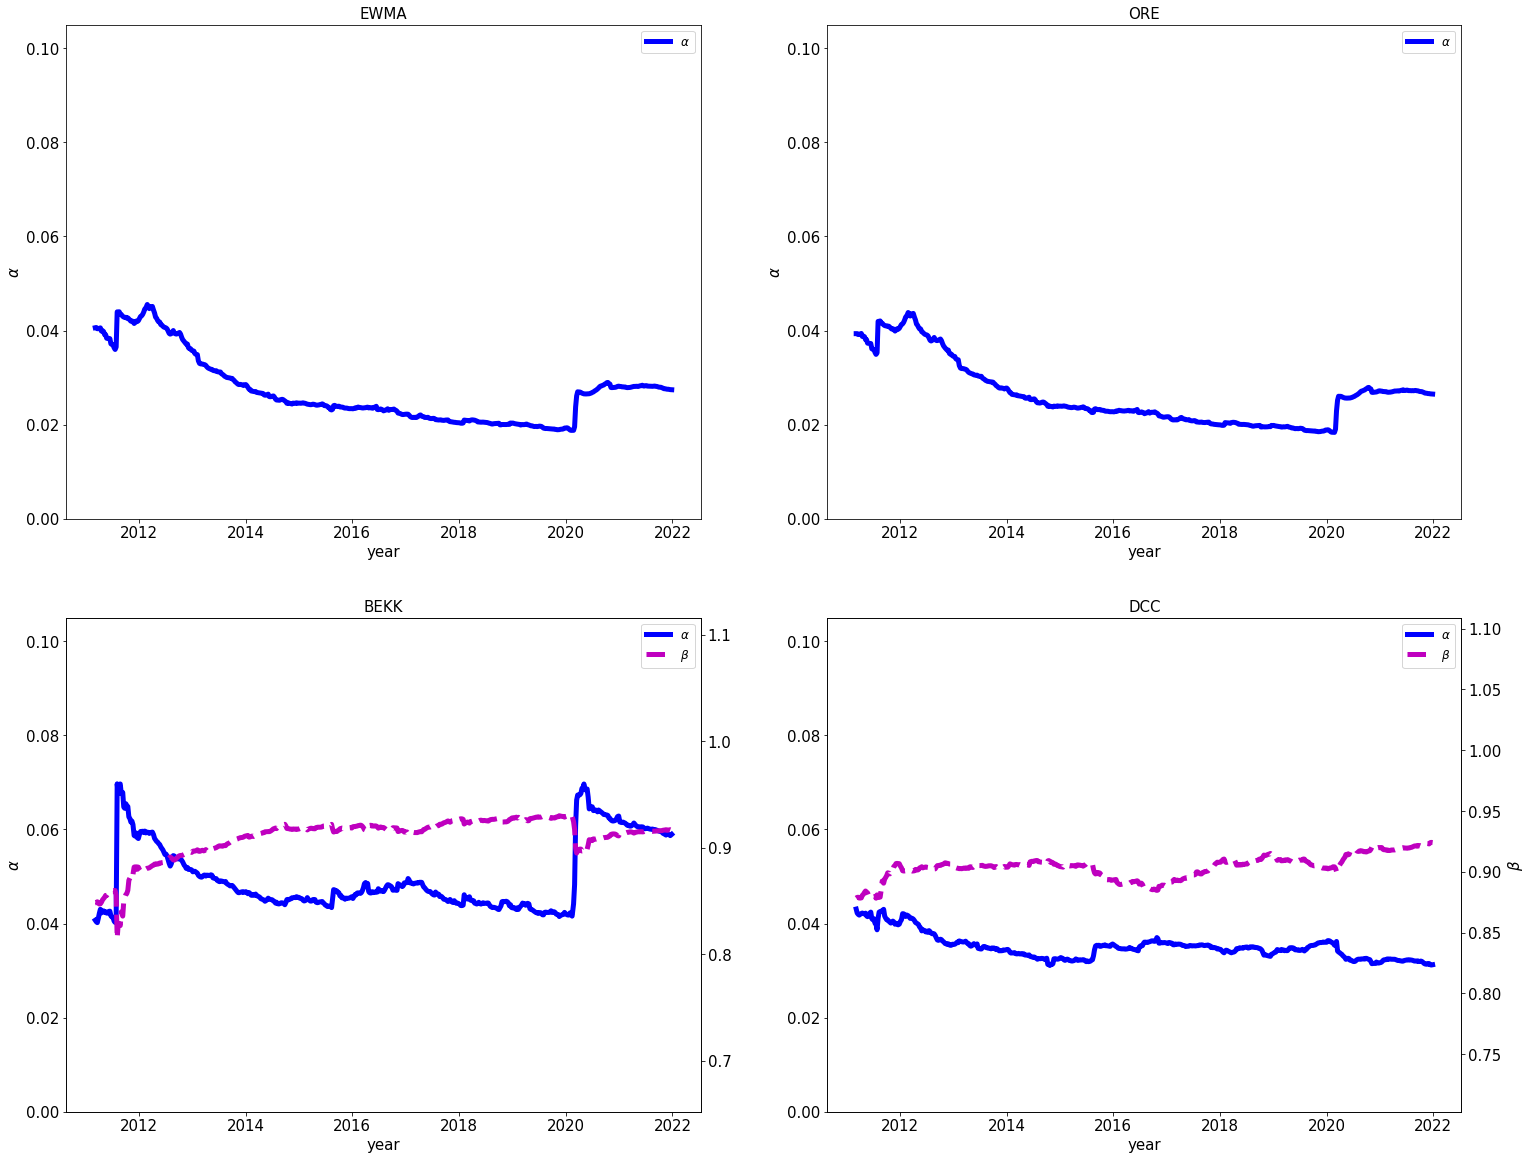

In [23]:
    #Create figure used in thesis, might not work
    Models = ['EWMA',"ORE", 'BEKK', 'DCC']
    #method =['ML','SVD', 'NCLM','FCLM']
    method =['NCLM']
    line_s=['solid','dotted','dashed','dashdot']
    line_c=['b','m','g','k']#['purple','blue','skyblue','deepskyblue']

    mx= 0.07

    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(25,20))
    for m in range(2):
        for n in range (2):
            axes[m,n].set_title(Models[n+2*m])
            if m*n!=1:
                axes[m,n].set_ylabel(r"$\alpha$" , color="black")
            for i in range(1):
                x=dates[range(295,T,5)]
                #y = params.iloc[(m+2*n)*4+i]
                y= params.iloc[(m*2+n)]
              # for p in range(len(y[0])):
             #   for p in range(len(y[0,0])):
                for p in range(len(y.iloc[0])):
                    if p==0:                                       
                        par = np.array([item[p] for item in y])                    
                        a = axes[m,n].plot(x,par,color=line_c[i], lw=5, ls='-', label=(r"$\alpha$ "))
                        axes[m,n].set_ylim(0,mx*1.5)                    
                    if p ==1:
                        par = np.array([item[p] for item in y])  
                        if i ==0:
                            ax2= axes[m,n].twinx()
                            if n==1:
                                ax2.set_ylabel(r"$\beta$" , color="black")
                            ax2.set_ylim(par.min()*0.8,par.max()*1.2)                        
                            b= ax2.plot(x,par,color=line_c[i+1], lw=5, ls='--', label=(r"$\beta$ "))
                            lns=a+b 
                            labs = [l.get_label() for l in lns]

            if p==0:
                axes[m,n].legend(loc = 'upper right')
            else:
                axes[m,n].legend(lns, labs, loc = 'upper right')  
            #ax2.legend(loc = 'lower right')  
            axes[m,n].set_xlabel("year" , color="black")

    #fig.savefig('paramest.pdf')

In [27]:
#setup matrices, comment out unwanted matrices
Ht_ewma =  np.zeros((N,N,T))   
Ht_ewma_svd = np.zeros((N,N,T))
Ht_comp_ewma = np.zeros((N,N,T))  
Ht_comp_ewma_full = np.zeros((N,N,T))  

Rt_dcc= np.zeros((N,N,T))   
Rt_dcc_svd = np.zeros((N,N,T))
Rt_comp_dcc= np.zeros((N,N,T))  
Rt_comp_dcc_full= np.zeros((N,N,T))  
Ht_dcc= np.zeros((N,N,T))   
Ht_dcc_svd = np.zeros((N,N,T))
Ht_comp_dcc= np.zeros((N,N,T))  
Ht_comp_dcc_full= np.zeros((N,N,T))  

Ht_svech= np.zeros((N,N,T))   
Ht_svech_svd = np.zeros((N,N,T))
Ht_comp_svech= np.zeros((N,N,T)) 
Ht_comp_svech_full= np.zeros((N,N,T))  

Ht_ore= np.zeros((N,N,T))   
Ht_ore_svd = np.zeros((N,N,T))
Ht_comp_ore= np.zeros((N,N,T))  
Ht_comp_ore_full= np.zeros((N,N,T))  

estimates_names =[
'EWMA_est',
'EWMA_svd_est',
'EWMA_comp_est',
'DCC_est',
'DCC_svd_est',
'DCC_comp_est',
'SVECH_est',
'SVECH_svd_est',
'SVECH_comp_est',
'ORE_est',
'ORE_svd_est',
'ORE_comp_est'
]

In [28]:
#inefficient as hell, but does the trick
threshold=10 
if params.shape[1] > threshold:
    for a,t in enumerate(Time_cutoff):
        if t == Time_cutoff[0]:
            s=0
        else:
            s= Time_cutoff[0]

        print(i,s,t) 
        Ht_ewma[:,:,s:t] = EWMA.ewma_est_H(params.loc['EWMA_est'][i],ret[:t],init_step)[:,:,s:]        
        Ht_ewma_svd [:,:,s:t] = EWMA.ewma_est_H(params.loc['EWMA_svd_est'][i],ret[:t],init_step)[:,:,s:]   
        Ht_comp_ewma[:,:,s:t] = EWMA.ewma_est_H(params.loc['EWMA_comp_est'][i],ret[:t],init_step)[:,:,s:] 
        Ht_comp_ewma_full[:,:,s:t] = EWMA.ewma_est_H(params.loc['EWMA_comp_est_full'][i],ret[:t],init_step)[:,:,s:]
        Rt_dcc[:,:,s:t] = DCC.dcceq(params.loc['DCC_est'][i],ret[:t],D_inv[:t,:],init_step)[:,:,s:]         
        Rt_dcc_svd[:,:,s:t] = DCC.dcceq(params.loc['DCC_svd_est'][i],ret[:t],D_inv[:t,:],init_step)[:,:,s:]         
        Rt_comp_dcc[:,:,s:t] = DCC.dcceq(params.loc['DCC_comp_est'][i],ret[:t],D_inv[:t,:],init_step)[:,:,s:]    
        Rt_comp_dcc_full[:,:,s:t] = DCC.dcceq(params.loc['DCC_comp_est_full'][i],ret[:t],D_inv[:t,:],init_step)[:,:,s:]   
        Ht_svech[:,:,s:t] = SV.svech_est_H(params.loc['SVECH_est'][i],ret[:t],init_step)[:,:,s:]   
        Ht_svech_svd[:,:,s:t] = SV.svech_est_H(params.loc['SVECH_svd_est'][i],ret[:t],init_step)[:,:,s:]   
        Ht_comp_svech[:,:,s:t]= SV.svech_est_H(params.loc['SVECH_comp_est'][i],ret[:t],init_step)[:,:,s:]   
        Ht_comp_svech_full[:,:,s:t]= SV.svech_est_H(params.loc['SVECH_comp_est_full'][i],ret[:t],init_step)[:,:,s:]  
        Ht_ore[:,:,s:t]= ORE.ore_est_H(params.loc['ORE_est'][i],ret[:t],init_step)[:,:,s:]     
        Ht_ore_svd[:,:,s:t] = ORE.ore_est_H(params.loc['ORE_svd_est'][i],ret[:t],init_step)[:,:,s:]     
        Ht_comp_ore[:,:,s:t]=  ORE.ore_est_H(params.loc['ORE_comp_est'][i],ret[:t],init_step)[:,:,s:]   
        Ht_comp_ore_full[:,:,s:t]=  ORE.ore_est_H(params.loc['ORE_comp_est_full'][i],ret[:t],init_step)[:,:,s:]   


    for t in range(T):
        Ht_dcc[:,:,t] = np.matmul(np.matmul(np.diagflat(D_diag[t,:]),Rt_dcc[:,:,t]),np.diagflat(D_diag[t,:]))
        Ht_dcc_svd[:,:,t] = np.matmul(np.matmul(np.diagflat(D_diag[t,:]),Rt_dcc_svd[:,:,t]),np.diagflat(D_diag[t,:]))
        Ht_comp_dcc[:,:,t] = np.matmul(np.matmul(np.diagflat(D_diag[t,:]),Rt_comp_dcc[:,:,t]),np.diagflat(D_diag[t,:]))
        Ht_comp_dcc_full[:,:,t] = np.matmul(np.matmul(np.diagflat(D_diag[t,:]),Rt_comp_dcc_full[:,:,t]),np.diagflat(D_diag[t,:]))

0 0 300


KeyError: 'EWMA_est'

In [29]:
#setup matrices used in the case when the estimates with 5 day frequency for neighbouring CML were obtained
Ht_comp_ewma = np.zeros((N,N,T)) 
Rt_comp_dcc= np.zeros((N,N,T))  
Ht_comp_dcc= np.zeros((N,N,T)) 
Ht_comp_svech= np.zeros((N,N,T))
Ht_comp_ore= np.zeros((N,N,T))  

estimates_names =[
'EWMA_comp_est',
'DCC_comp_est',
'SVECH_comp_est',
'ORE_comp_est'
]

In [30]:
Time_cutoff =[]
#inefficient as hell, but does the trick
for t in range(300,T,5):
     Time_cutoff.append(t)
if Time_cutoff[-1] != T:
    Time_cutoff.append(T)
for i,t in enumerate(Time_cutoff[1:]):
    if t == Time_cutoff[1]:
        s=0
    else:
        s= Time_cutoff[i]
    print(i,s,t) 
    Ht_comp_ewma[:,:,s:t] = EWMA.ewma_est_H(params.loc['EWMA',t],ret[:t],init_step)[:,:,s:]  
    Rt_comp_dcc[:,:,s:t] = DCC.dcceq(params.loc['DCC',t],ret[:t],D_inv[:t,:],init_step)[:,:,s:]     
    Ht_comp_svech[:,:,s:t]= SV.svech_est_H(params.loc['BEKK',t],ret[:t],init_step)[:,:,s:]   
    Ht_comp_ore[:,:,s:t]=  ORE.ore_est_H(params.loc['ORE',t],ret[:t],init_step)[:,:,s:]   


for t in range(T):   
    Ht_comp_dcc[:,:,t] = np.matmul(np.matmul(np.diagflat(D_diag[t,:]),Rt_comp_dcc[:,:,t]),np.diagflat(D_diag[t,:]))

0 0 305
1 305 310
2 310 315
3 315 320
4 320 325
5 325 330
6 330 335
7 335 340
8 340 345
9 345 350
10 350 355
11 355 360
12 360 365
13 365 370
14 370 375
15 375 380
16 380 385
17 385 390
18 390 395
19 395 400
20 400 405
21 405 410
22 410 415
23 415 420
24 420 425
25 425 430
26 430 435
27 435 440
28 440 445
29 445 450
30 450 455
31 455 460
32 460 465
33 465 470
34 470 475
35 475 480
36 480 485
37 485 490
38 490 495
39 495 500
40 500 505
41 505 510
42 510 515
43 515 520
44 520 525
45 525 530
46 530 535
47 535 540
48 540 545
49 545 550
50 550 555
51 555 560
52 560 565
53 565 570
54 570 575
55 575 580
56 580 585
57 585 590
58 590 595
59 595 600
60 600 605
61 605 610
62 610 615
63 615 620
64 620 625
65 625 630
66 630 635
67 635 640
68 640 645
69 645 650
70 650 655
71 655 660
72 660 665
73 665 670
74 670 675
75 675 680
76 680 685
77 685 690
78 690 695
79 695 700
80 700 705
81 705 710
82 710 715
83 715 720
84 720 725
85 725 730
86 730 735
87 735 740
88 740 745
89 745 750
90 750 755
91 755 760


## Calculate portfolio performance
a few methods of calculating and drawing portfolio performance connected variables and matrics

In [31]:
#A few methods to show porfolio performance
def calc_perf(w,rets):
    T = w.shape[0]
   
    perf = []
    for t in range(T):
        perf_t = np.matmul(w[t,:], rets[t,:].T)
        perf.append(perf_t)
    port_perf = np.array(perf)
    return port_perf

def calc_cum_perf(daily_ret):
    T = daily_ret.shape[0]    
    daily_perf = daily_ret + 1
    gains= np.ones(T)
   
    for cnt in range(T):
        if cnt ==0 :
             gains[cnt] = daily_perf[cnt]
        else:
             gains[cnt] = gains[cnt-1] * daily_perf[cnt]
    return gains

def calc_turnover(weights):
    T = weights.shape[0]
    turnover = np.zeros((T))
    turnover[0]=0
    for t in range(1,T):
        turnover[t] =  sum(abs(weights[t,:]- weights[t-1,:]))
    
    return turnover
    

def see_perf(ws,m_names, rets, draw_ind_stocks = True):
    
    fig, ax1 = plt.subplots(figsize=(15, 10))   
    # ax2 = ax1.twinx()
    linew = 4
    T,N = rets.shape
    x= dates[cut_start:cut_end]
    M= len(ws)
    maxgain =0   
    ls="solid"
    color =[]
    for m,w in enumerate(ws):
        if m!=0:
            color.append(next(ax1._get_lines.prop_cycler)['color'])
        gains= np.ones(T)
        perf = calc_perf(w, rets)
        perf += 1
        
        for cnt,a in enumerate(perf):
            if cnt ==0:
                gains[0]= perf[0]
            else:
                gains[cnt] = gains[cnt-1] * perf[cnt]
            
        gains = np.array(gains)
        if maxgain < gains[-1]:
            maxgain = gains[-1]
        if draw_ind_stocks == True:       
            ax1.plot(x,gains,lw=linew, label = m_names[m])
        else:   
            if ((m>5)& (m<=10)):
                ls= (0, (5, 1))
                print(m,ls,m_names[m])
            else:
                ls="solid"
                print(m,ls,m_names[m])
            if m==0:
                col='black'
            else:
                col= color[(m-1) %5 ]
            ax1.plot(x,gains,lw=3, label = m_names[m],ls=ls, color=col)
       # ax2.plot(perf, color=  'blue')
    
    if draw_ind_stocks == True:   
        for stock in range(N):
            ind_gain= np.ones(T)
            ind_gain[0] = rets[0,stock]+1
            for cnt in range(1,T):              
                ind_gain[cnt] = ind_gain[cnt-1] * (rets[cnt,stock]+1)
            ind_gain = np.array(ind_gain)
            if ind_gain[-1]>maxgain:
                ax1.plot(ind_gain, alpha=.25, label=assets[stock] )
            else:
                ax1.plot(ind_gain, alpha=.25)

    ax1.legend()    
    
    ax1.set_ylabel('cumulative return')
   # ax2.set_ylabel('daily return')
 
    return fig


## Draw port performance

In [32]:
# See properties of all models 
def ind_model_performance(model_names,mean_tuple,disc_mean_tuple, var_tuple,
                          weights,shrape_tuple,turnover_tuple,
                         eq_ret_disc=None,eq_var=None,ind =0, MA_window = 50):
    
   
    fig, (ax1, ax2, ax3,ax4,ax5,ax6) =  plt.subplots( 6, figsize=(15, 30)) 
    ax1.set_title('Mean portfolio delta-adjusted and non-adjusted mean returns')
    ax2.set_title('Delta-adjusted porfolio standard deviation')
    ax3.set_title('Final model weights')
    ax4.set_title('Sharpe ratios')
    ax5.set_title('Portfolio Turnover')
    ax6.set_title('Portfolio Turnover moving average')
    for i in range(len(model_names)):
        ax1.plot(mean_tuple[i][ind:])
        ax1.plot(mean_disc_tuple[i][ind:], label = model_names[i])
        ax2.plot(np.sqrt(var_tuple[i][ind:]),  label = model_names[i])
        ax3.plot(weights[i,:][ind:],  label = model_names[i])
        ax4.plot(shrape_tuple[i][ind:], label = model_names[i])
        ax5.plot(turnover_tuple[i][ind:], label = model_names[i])
        ax6.plot(pd.Series(turnover_tuple[i][ind:]).rolling(window=MA_window, min_periods=1).mean()
                , label = model_names[i]+' MA ' + str(MA_window))

        ax6.plot(turnover_tuple[i][ind:].mean()*np.ones(len(turnover_tuple[i][ind:])),lw = 2, label = model_names[i]+' mean' )
    
         
    if eq_ret_disc.any()!= None:
        ax1.plot(eq_ret_disc[ind:], label ='Stocks Equal Weights')
        ax2.plot(np.sqrt(eq_mean_var[ind:]), label ='Stocks Equal Weights')

    ax1.legend(loc= 'upper left')    
    ax2.legend(loc= 'upper left')
    ax3.legend(loc= 'upper left') 
    ax4.legend(loc= 'upper left')  
    ax5.legend(loc= 'upper left')  
    ax6.legend(loc= 'upper left') 
    #fig.show
    
    return fig
    

In [33]:
# See properties of all models 
def ind_model_performance2(model_names,disc_mean_tuple, var_tuple,
                          turnover_tuple,beta_tuple,shrape_tuple,sortino_tuple,treinor_tuple,
                         eq_tuple=None,ind =0, MA_window = 50):
    
   
    fig, (ax1, ax2, ax3,ax4,ax5,ax6,ax7) =  plt.subplots( 7, figsize=(12, 30)) 
    ax1.set_title('Mean portfolio returns')
    ax2.set_title('Portfolio standard deviation')
    ax3.set_title('Portfolio turnover')
    ax4.set_title('Porfolio beta')
    ax5.set_title('Sharpe ratios')
    ax6.set_title('Sortino ratios')
    ax7.set_title('Trainors index')
    for i in range(len(model_names)): 
        color = next(ax1._get_lines.prop_cycler)['color']
        ax1.plot(mean_disc_tuple[i][ind:], label = model_names[i], color=color)
        ax2.plot(np.sqrt(var_tuple[i][ind:]),  label = model_names[i], color=color)
        ax3.plot(pd.Series(turnover_tuple[i][ind:]).rolling(window=MA_window, min_periods=1).mean()
                ,color=color) #label = model_names[i]+' MA ' + str(MA_window)
        ax3.plot(turnover_tuple[i][ind:].mean()*np.ones(len(turnover_tuple[i][ind:])),lw = 2,
                 label = model_names[i], color=color )
        ax4.plot(beta_tuple[i][ind:], label = model_names[i], color=color)
        ax5.plot(shrape_tuple[i][ind:], label = model_names[i], color=color)
        ax6.plot(sortino_tuple[i][ind:], label = model_names[i], color=color)
        ax7.plot(treinor_tuple[i][ind:], label = model_names[i], color=color)


    
         
    if eq_tuple!= None:
        lb= 'Stocks Equal Weights'
        color = 'black'
        ax1.plot(eq_tuple[0][ind:], label =lb,color=color)
        ax2.plot(np.sqrt(eq_tuple[1][ind:]), label =lb,color=color)
    
        ax4.plot(eq_tuple[2][ind:], label = lb,color=color)
        ax5.plot(eq_tuple[3][ind:], label = lb,color=color)
        ax6.plot(eq_tuple[4][ind:], label = lb,color=color)
        ax7.plot(eq_tuple[5][ind:], label = lb,color=color)

    ax1.legend(loc= 'upper left')    
    ax2.legend(loc= 'upper left')
    ax3.legend(loc= 'upper left') 
    ax4.legend(loc= 'upper left')  
    ax5.legend(loc= 'upper left')  
    ax6.legend(loc= 'upper left') 
    ax7.legend(loc= 'upper left') 
    #fig.show
    
    return fig

In [34]:
# See properties of all models 
def ind_model_performance3(model_names,disc_mean_tuple, var_tuple,
                          turnover_tuple,beta_tuple,
                         eq_tuple=None,ind =0, MA_window = 50):
    
    linew=3   

    fig, (ax1, ax2, ax3,ax4) =  plt.subplots( 4, figsize=(14, 22)) 
    ax1.set_title('Mean portfolio returns')
    ax2.set_title('Portfolio standard devation')
    ax3.set_title('Portfolio turnover')
    ax4.set_title('Porfolio beta')
  #  ax5.set_title('Sharpe ratios')
  #  ax6.set_title('Sortino ratios')
  #  ax7.set_title('Trainors index')
    x=dates[ind:]
    for i in range(len(model_names)): 
        color = next(ax1._get_lines.prop_cycler)['color']
        ax1.plot(x,mean_disc_tuple[i][ind:], label = model_names[i], color=color,lw=linew)
        ax2.plot(x,np.sqrt(var_tuple[i][ind:]),  label = model_names[i], color=color,lw=linew)
        ax3.plot(x,pd.Series(turnover_tuple[i][ind:]).rolling(window=MA_window, min_periods=1).mean()
                ,label = model_names[i],color=color,lw=linew-0.5) #label = model_names[i]+' MA ' + str(MA_window)
        ax3.plot(x,turnover_tuple[i][ind:].mean()*np.ones(len(turnover_tuple[i][ind:])),lw = linew+0.5,ls='dashed',
                  color=color)
        ax4.plot(x,beta_tuple[i][ind:], label = model_names[i], color=color,lw=linew)
       # ax5.plot(shrape_tuple[i][ind:], label = model_names[i], color=color)
     #   ax6.plot(sortino_tuple[i][ind:], label = model_names[i], color=color)
    #    ax7.plot(treinor_tuple[i][ind:], label = model_names[i], color=color)


    
         
    if eq_tuple!= None:
        lb= 'Stocks Equal Weights'
        color = 'black'
        ax1.plot(x,eq_tuple[0][ind:], label =lb,color=color,lw=linew)
        ax2.plot(x,np.sqrt(eq_tuple[1][ind:]), label =lb,color=color,lw=linew)
    
        ax4.plot(x,eq_tuple[2][ind:], label = lb,color=color,lw=linew)
    #    ax5.plot(eq_tuple[3][ind:], label = lb,color=color)
   #     ax6.plot(eq_tuple[4][ind:], label = lb,color=color)
    #    ax7.plot(eq_tuple[5][ind:], label = lb,color=color)

    ax1.legend(loc= 'upper left')    
    ax2.legend(loc= 'upper left')
    ax3.legend(loc= 'upper left') 
    ax4.legend(loc= 'upper left')  
   # ax5.legend(loc= 'upper left')  
  #  ax6.legend(loc= 'upper left') 
  #  ax7.legend(loc= 'upper left') 
    #fig.show
    
    return fig

## Mean-Variance problem under forecast combination

In [35]:
#Two methods to estimate stock expected returns
def rolling_mean(mat, wind): #get column-wise rolling mean 
    rmean= []
    T,N= ret.shape
    for col in range(N):
        rmean.append( pd.Series(mat[:,col]).rolling(window=wind, min_periods=1).mean())
    
    mu = np.array(rmean).T
    return mu   

def discounted_rolling_mean(mat,deltas):
    dmean= []
    T,N= ret.shape
    d = deltas[1]
    for t in range(T):
        if d == 1:
            dmean.append(1/(t+1)*np.matmul(deltas[:t+1][::-1].T, mat[:t+1]))
        else:
            dmean.append((1 - d)/(1 - d**(max(t,2)-1))*np.matmul(deltas[:t+1][::-1].T, mat[:t+1]))
    
    return np.array(dmean)

In [36]:
def meanvar(H, mu,mu_0):
    w =[]
    T = H.shape[2]
    for t in range(T):
        Ht=H[:,:,t]
        if t == 0:
            mu_t = np.array(mu[t,:],ndmin = 2).T
        else:
            mu_t = np.array(mu[t-1,:],ndmin = 2).T
       
        Ht_inv = np.linalg.inv(Ht) # u had **2 here for some reason
        ones = np.array(np.ones(N), ndmin=2).T #column vector of ones
        A = np.matmul(np.matmul(mu_t.T, Ht_inv), mu_t)
        B = np.matmul(np.matmul(mu_t.T, Ht_inv), ones)
        C = np.matmul(np.matmul(ones.T,Ht_inv),ones)
      
        nom = np.matmul(mu_t, mu_0*C -B) + np.matmul(ones , A - mu_0 * B) 
        denom = A * C - B**2

        w.append(np.divide(np.matmul(Ht_inv, nom), denom))
    
    weights = np.array(w)
    weights = np.squeeze(weights)
    return weights

## Min var problem under forecast information

In [37]:
def minvar(H):
    w =[]
    T = H.shape[2]
    for t in range(T):
        Ht=H[:,:,t]
        Ht_inv = np.linalg.inv(Ht)
        ones = np.array(np.ones(N), ndmin=2).T #column vector of ones
        w_t = np.matmul(ones.T,Ht_inv) #not normalized
        denom = np.matmul(w_t, ones)
        w_t = np.divide(w_t.T, denom)
        w.append(w_t)
            
    weights = np.array(w)
    weights  = np.squeeze(weights)
    return weights

## Risk adjusted performance metrics

In [38]:
def port_return(w, ret, deltas):
    d = deltas[1]
    T = ret.shape[0]
    day_perf =np.zeros(T)
    day_perf_disc= np.zeros(T)
    mean_port_ret= np.zeros(T)
    mean_port_ret_disc= np.zeros(T)
    
    for t in range(0,T):
        day_perf[t] = np.array(np.matmul(np.array(ret[t,:],ndmin =2), w[t,:]  ),ndmin =2)
        mean_port_ret[t] = 1/(max(t,2)-1)*sum(day_perf[:t])
        if d!=1:
            mean_port_ret_disc[t]= (1 - d)/(1 - d**(max(t,2)-1))*np.matmul(day_perf[:t+1],deltas[:t+1][::-1])
        else:
            mean_port_ret_disc[t]= 1/max(t+1,1)*np.matmul(day_perf[:t+1],deltas[:t+1][::-1])
        #[::-1] reverses the array
        
    return day_perf, mean_port_ret, mean_port_ret_disc

def port_return_costadj(w, ret,turn):
   
    T = ret.shape[0]
    day_perf_costadj =np.zeros(T)
    c_list =np.array([0,5,10,15,20])*0.0001
    gain=[1,1,1,1,1]
    
    for t in range(0,T):
        day_perf_costadj[t] = np.array(np.matmul(np.array(ret[t,:]+1,ndmin =2), w[t,:]  ),ndmin =2)
        for i,c in enumerate(c_list):
            gain[i] = gain[i]*day_perf_costadj[t]*(1-c*turn[t])
    return gain


def port_variance(daily_perf, mu_m, deltas,start=0):
    T = daily_perf.shape[0]
    d= deltas[1]
    m_var= np.zeros(T)
    for t in range(start,T):
        if d!=1:
            m_var[t] = np.array(np.matmul(((daily_perf[:t+1]-mu_m[t])**2), deltas[:t+1][::-1]).sum()*((1 - d)/(1 - d**(max(t,2)-1))))
        else:
            m_var[t] = np.array(np.matmul(((daily_perf[:t+1]-mu_m[t])**2), deltas[:t+1][::-1]).sum()*1/t)
    return m_var

def port_downside_variance(daily_perf, mu_m, deltas,start=0):
    T = daily_perf.shape[0]
    d= deltas[1]
    m_down_var= np.zeros(T)
    down_perf= np.where(daily_perf>0, 0, daily_perf)
    for t in range(start,T):
        if d!=1:
            m_down_var[t] = np.array(np.matmul((down_perf[:t+1]**2), deltas[:t+1][::-1]).sum()*((1 - d)/(1 - d**(max(t,2)-1))))
        else:
            m_down_var[t] = np.array(np.matmul((down_perf[:t+1]**2), deltas[:t+1][::-1]).sum()*1/t)
        
    m_down_var= np.where(((m_down_var<0.000001)&(m_down_var>0)), 0.000001, m_down_var)
    m_down_var= np.where(((m_down_var>-0.000001)&(m_down_var<0)), -0.000001, m_down_var)
    return m_down_var
    
def sharpe_ratio(model_ret,model_variance,minvar=False):
    if minvar==True:
        return np.ones(model_ret.shape[0])/np.sqrt(model_variance)
        
    return (model_ret/np.sqrt(model_variance))

#TODO
def sortino_ratio(model_ret,model_down_variance,minvar=False):
    if minvar == True:
        return np.ones(model_ret.shape[0])/np.sqrt(model_down_variance)
    SR = model_ret/np.sqrt(model_down_variance)
    return SR
    
def port_beta(daily_perf,mu_m, index_dperf,deltas,start =1):
    T = daily_perf.shape[0]
    d= deltas[1]
    betas= np.zeros(T)
    mean_index_ret = np.zeros(T)
    betas[0]=1
    for t in range(start,T):
        mean_index_ret[t] = 1/(max(t,2)-1)*sum(index_dperf[:min(t+1,T)])
        if d!=1:
            betas[t] = np.array(np.matmul(((daily_perf[:t+1] - mu_m[t])*(index_dperf[:t+1,0] - mean_index_ret[t])).T, deltas[:t+1][::-1]).sum()*((1 - d)/(1 - d**(max(t,2)-1))))
            denom = np.matmul(((index_dperf[:t+1,0] - mean_index_ret[t])**2).T, deltas[:t+1][::-1]).sum()*((1 - d)/(1 - d**(max(t,2)-1)))
        else:
            betas[t] = np.array(np.matmul(((daily_perf[:t+1] - mu_m[t])*(index_dperf[:t+1,0] - mean_index_ret[t])).T, deltas[:t+1][::-1]).sum()*1/t)
            denom = np.matmul(((index_dperf[:t+1,0] - mean_index_ret[t])**2).T, deltas[:t+1][::-1]).sum()*1/t
        betas[t]= betas[t]/denom
    betas= np.where(((betas<0.01)&(betas>0)), 0.01, betas)
    betas= np.where(((betas>-0.01)&(betas<0)), -0.01, betas)
    return betas

def trainors_index(model_ret,beta):  
    TI = model_ret/ abs(beta)
    return TI
    
    

## Introduce a discount parameter

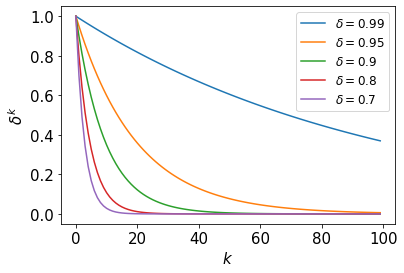

In [39]:
for delta in (0.99,0.95,0.9,0.8,0.7):
    deltas = np.zeros(T)
    deltas[0] = 1
    deltas[1] = delta    
    for t in range(2,T):
        deltas[t] = deltas[t-1]*delta
    plt.plot(deltas[:100], label = r"$\delta=$" + str(delta))
    plt.legend()   
    plt.xlabel(r'$k $' , color="black", fontsize = 15)
    plt.ylabel(r'$\delta^k $' , color="black", fontsize = 15)
    plt.savefig('dicountParam_prez.pdf')

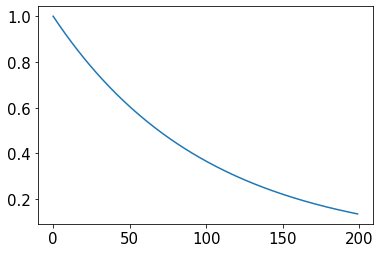

In [41]:
delta= 0.99
deltas = np.zeros(T)
deltas[0] = 1
deltas[1] = delta
for t in range(2,T):
    deltas[t] = deltas[t-1]*delta
plt.plot(deltas[:200])

# Estimating the combined matix


## Mean-var 

In [42]:
use_composite_est = True


In [45]:
mu = rolling_mean(ret, 500) #column vector of expected returns


In [46]:
mu[:,:10].shape

(3020, 10)

In [49]:

#mu = ret.mean(axis = 0)*0
#mu = discounted_rolling_mean(ret,deltas) #Smaller turnover when delta relatively close to 1

daily_exp_ret = 0.0005

if use_composite_est==False:
    mean_w_ccc = meanvar(Ht_ccc, mu, daily_exp_ret)
    mean_w_svech = meanvar(Ht_svech, mu, daily_exp_ret)
    mean_w_ore = meanvar(Ht_ore, mu, daily_exp_ret)
    mean_w_dcc = meanvar(Ht_dcc, mu, daily_exp_ret)
    mean_w_ewma = meanvar(Ht_ewma, mu, daily_exp_ret)
else:
    mean_w_svech = meanvar(Ht_comp_svech, mu, daily_exp_ret)
    mean_w_ore = meanvar(Ht_comp_ore, mu, daily_exp_ret)
    mean_w_dcc = meanvar(Ht_comp_dcc, mu, daily_exp_ret)
    mean_w_ewma = meanvar(Ht_comp_ewma, mu, daily_exp_ret)
    mean_w_ccc = meanvar(Ht_ccc, mu, daily_exp_ret)
    
equal_weights = np.ones((T,N))*1/N

mean_turn_svech = calc_turnover(mean_w_svech)
mean_turn_ore = calc_turnover(mean_w_ore)
mean_turn_dcc = calc_turnover(mean_w_dcc)
mean_turn_ewma = calc_turnover(mean_w_ewma)
mean_turn_ccc = calc_turnover(mean_w_ccc)

In [50]:
svech_mean_dperf, svech_mean_ret, svech_mean_ret_disc =  port_return(mean_w_svech,ret,deltas) 
ore_mean_dperf, ore_mean_ret, ore_mean_ret_disc =  port_return(mean_w_ore,ret,deltas)
ccc_mean_dperf, ccc_mean_ret, ccc_mean_ret_disc = port_return(mean_w_ccc,ret,deltas)
dcc_mean_dperf, dcc_mean_ret, dcc_mean_ret_disc =  port_return(mean_w_dcc,ret,deltas)
ewma_mean_dperf, ewma_mean_ret, ewma_mean_ret_disc  =  port_return(mean_w_ewma,ret,deltas)
eq_mean_dperf, eq_mean_ret, eq_mean_ret_disc = port_return(equal_weights,ret,deltas)

In [51]:
#use undiscounted mean performance here? 
svech_mean_var =  port_variance(svech_mean_dperf,svech_mean_ret,deltas)
ore_mean_var =  port_variance(ore_mean_dperf,ore_mean_ret,deltas)
dcc_mean_var =  port_variance(dcc_mean_dperf,dcc_mean_ret,deltas)
ccc_mean_var =  port_variance(ccc_mean_dperf,ccc_mean_ret,deltas)
ewma_mean_var =  port_variance(ewma_mean_dperf,ewma_mean_ret,deltas)
eq_mean_var =  port_variance(eq_mean_dperf,eq_mean_ret,deltas)

In [52]:
svech_mean_downvar =  port_downside_variance(svech_mean_dperf,svech_mean_ret,deltas)
ore_mean_downvar =  port_downside_variance(ore_mean_dperf,ore_mean_ret,deltas)
dcc_mean_downvar =  port_downside_variance(dcc_mean_dperf,dcc_mean_ret,deltas)
ccc_mean_downvar =  port_downside_variance(ccc_mean_dperf,ccc_mean_ret,deltas)
ewma_mean_downvar =  port_downside_variance(ewma_mean_dperf,ewma_mean_ret,deltas)
eq_mean_downvar =  port_downside_variance(eq_mean_dperf,eq_mean_ret,deltas)

In [53]:
svech_mean_beta =  port_beta(svech_mean_dperf, svech_mean_ret,SP_ret,deltas)
ore_mean_beta =  port_beta(ore_mean_dperf, ore_mean_ret,SP_ret,deltas)
ccc_mean_beta =  port_beta(ccc_mean_dperf, ccc_mean_ret,SP_ret,deltas)
dcc_mean_beta =  port_beta(dcc_mean_dperf, dcc_mean_ret,SP_ret,deltas)
ewma_mean_beta =  port_beta(ewma_mean_dperf, ewma_mean_ret,SP_ret,deltas) 
eq_mean_beta = port_beta(eq_mean_dperf, eq_mean_ret,SP_ret,deltas) 

In [54]:
svech_mean_SR =  sharpe_ratio(svech_mean_ret_disc, svech_mean_var)
ore_mean_SR =  sharpe_ratio(ore_mean_ret_disc,ore_mean_var)
ccc_mean_SR =  sharpe_ratio(ccc_mean_ret_disc,ccc_mean_var)
dcc_mean_SR =  sharpe_ratio(dcc_mean_ret_disc,dcc_mean_var)
ewma_mean_SR =  sharpe_ratio(ewma_mean_ret_disc, ewma_mean_var)
eq_mean_SR = sharpe_ratio(eq_mean_ret_disc, eq_mean_var)

svech_mean_SoR =  sortino_ratio(svech_mean_ret_disc, svech_mean_downvar)
ore_mean_SoR =  sortino_ratio(ore_mean_ret_disc,ore_mean_downvar)
ccc_mean_SoR =  sortino_ratio(ccc_mean_ret_disc,ccc_mean_downvar)
dcc_mean_SoR =  sortino_ratio(dcc_mean_ret_disc,dcc_mean_downvar)
ewma_mean_SoR =  sortino_ratio(ewma_mean_ret_disc, ewma_mean_downvar)
eq_mean_SoR = sortino_ratio(eq_mean_ret_disc, eq_mean_downvar)


svech_mean_TI =  trainors_index(svech_mean_ret_disc, svech_mean_beta)
ore_mean_TI =  trainors_index(ore_mean_ret_disc, ore_mean_beta)
ccc_mean_TI =  trainors_index(ccc_mean_ret_disc, ccc_mean_beta)
dcc_mean_TI =  trainors_index(dcc_mean_ret_disc, dcc_mean_beta)
ewma_mean_TI =  trainors_index(ewma_mean_ret_disc, ewma_mean_beta)
eq_mean_TI =  trainors_index(eq_mean_ret_disc, eq_mean_beta)

<ipython-input-38-451199668720>:70: RuntimeWarning: divide by zero encountered in true_divide
  SR = model_ret/np.sqrt(model_down_variance)


In [55]:
#keep im mind that weights at time t have to detrmine positions for the next day t+1
ni = 1 #model weights aplification

models = (svech_mean_SR,ore_mean_SR,ccc_mean_SR,dcc_mean_SR,ewma_mean_SR)
model_names =('BEKK','ORE','CCC','DCC','EWMA')
M = len(models)
init_positions = np.ones(M) * 1/M

stack = np.stack(arrays = models)
stack= np.where(stack<0, 0, stack)
stack = stack **ni

cum_weights = stack.sum(axis = 0 )
model_mean_weights =  stack / cum_weights
model_mean_weights[:,0] = init_positions

indx= np.where(cum_weights<=0) #cases when all SRs are below zero - choose equal weights
model_mean_weights[:,indx]  =  1/M
model_mean_weights[:,0] =  1/len(models) # initial setup

shifted_mean_weights = np.roll(model_mean_weights, -1, axis=1)

shifted_mean_weights[:,0] = init_positions

shifted_mean_weights = np.insert(model_mean_weights, 0, init_positions, axis=1)   # initial setup
shifted_mean_weights = np.delete(shifted_mean_weights,obj = -1, axis =1)

<ipython-input-55-a16206ff311c>:14: RuntimeWarning: invalid value encountered in true_divide
  model_mean_weights =  stack / cum_weights


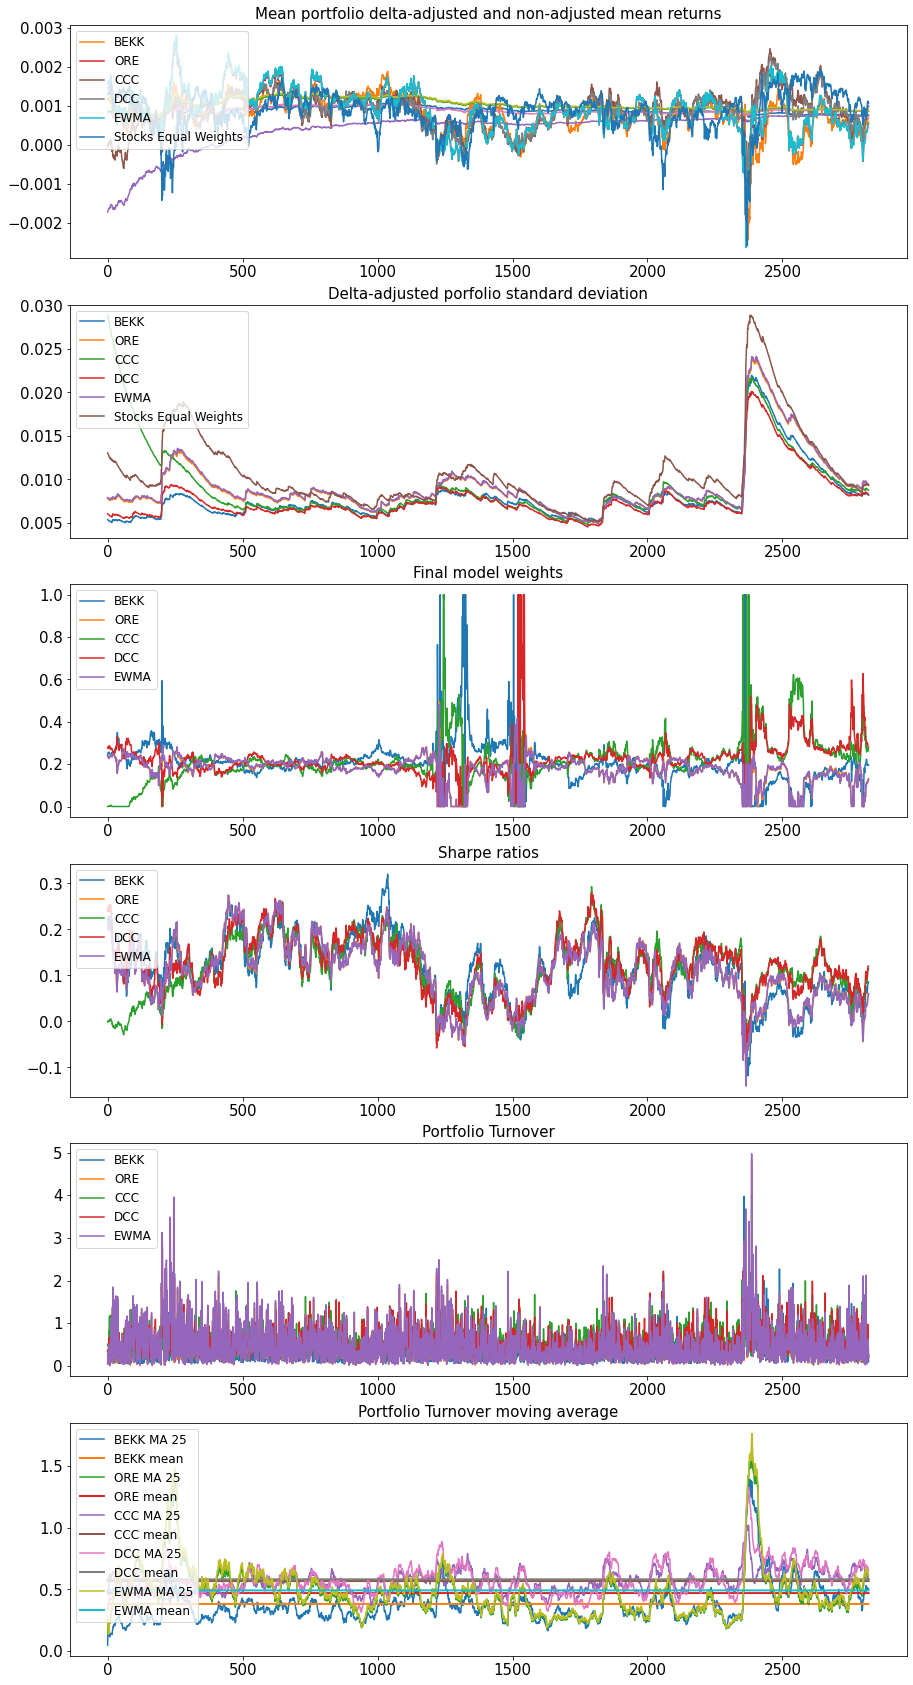

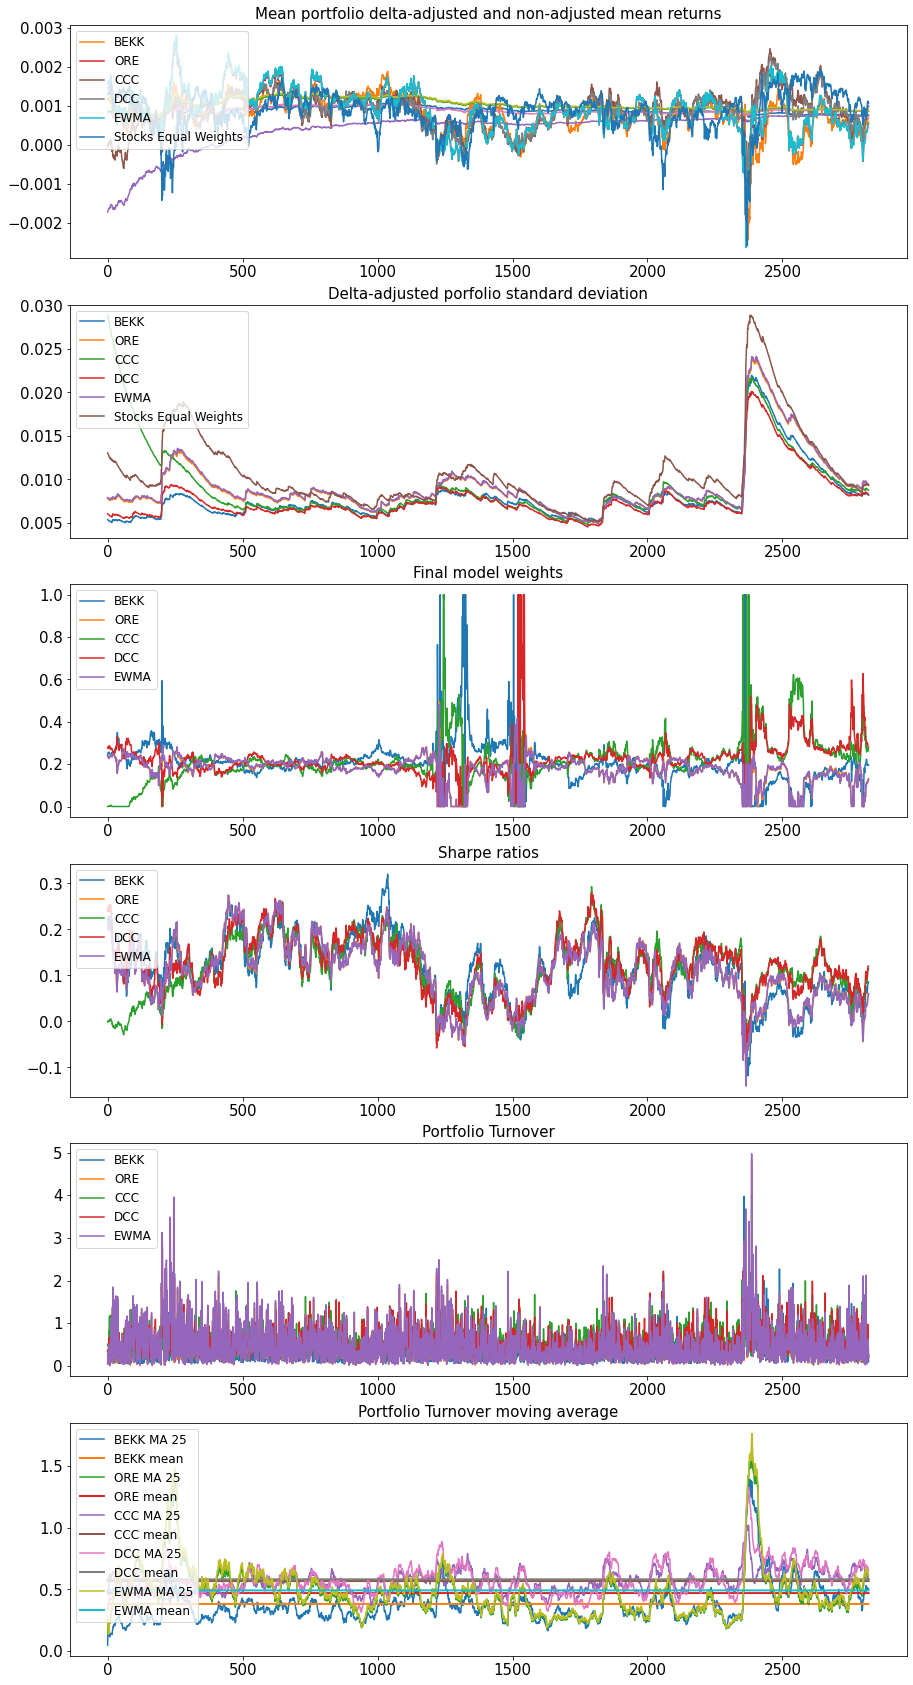

In [56]:
ind =300
mean_disc_tuple = (svech_mean_ret_disc,ore_mean_ret_disc,ccc_mean_ret_disc,
                   dcc_mean_ret_disc,ewma_mean_ret_disc,eq_mean_ret_disc)
mean_tuple = (svech_mean_ret,ore_mean_ret,ccc_mean_ret,dcc_mean_ret,
              ewma_mean_ret,eq_mean_ret)
var_mean_tuple = (svech_mean_var, ore_mean_var,ccc_mean_var, dcc_mean_var,ewma_mean_var, eq_mean_var)
mean_sharpe_tuple =  (svech_mean_SR,ore_mean_SR,ccc_mean_SR,dcc_mean_SR,ewma_mean_SR)
mean_turnover_tuple = (mean_turn_svech, mean_turn_ore,mean_turn_ccc, mean_turn_dcc, mean_turn_ewma)

ind_model_performance(model_names,mean_tuple,mean_disc_tuple,var_mean_tuple,
                      shifted_mean_weights,mean_sharpe_tuple,mean_turnover_tuple,
                      eq_mean_ret_disc,eq_mean_var,init_step,25)

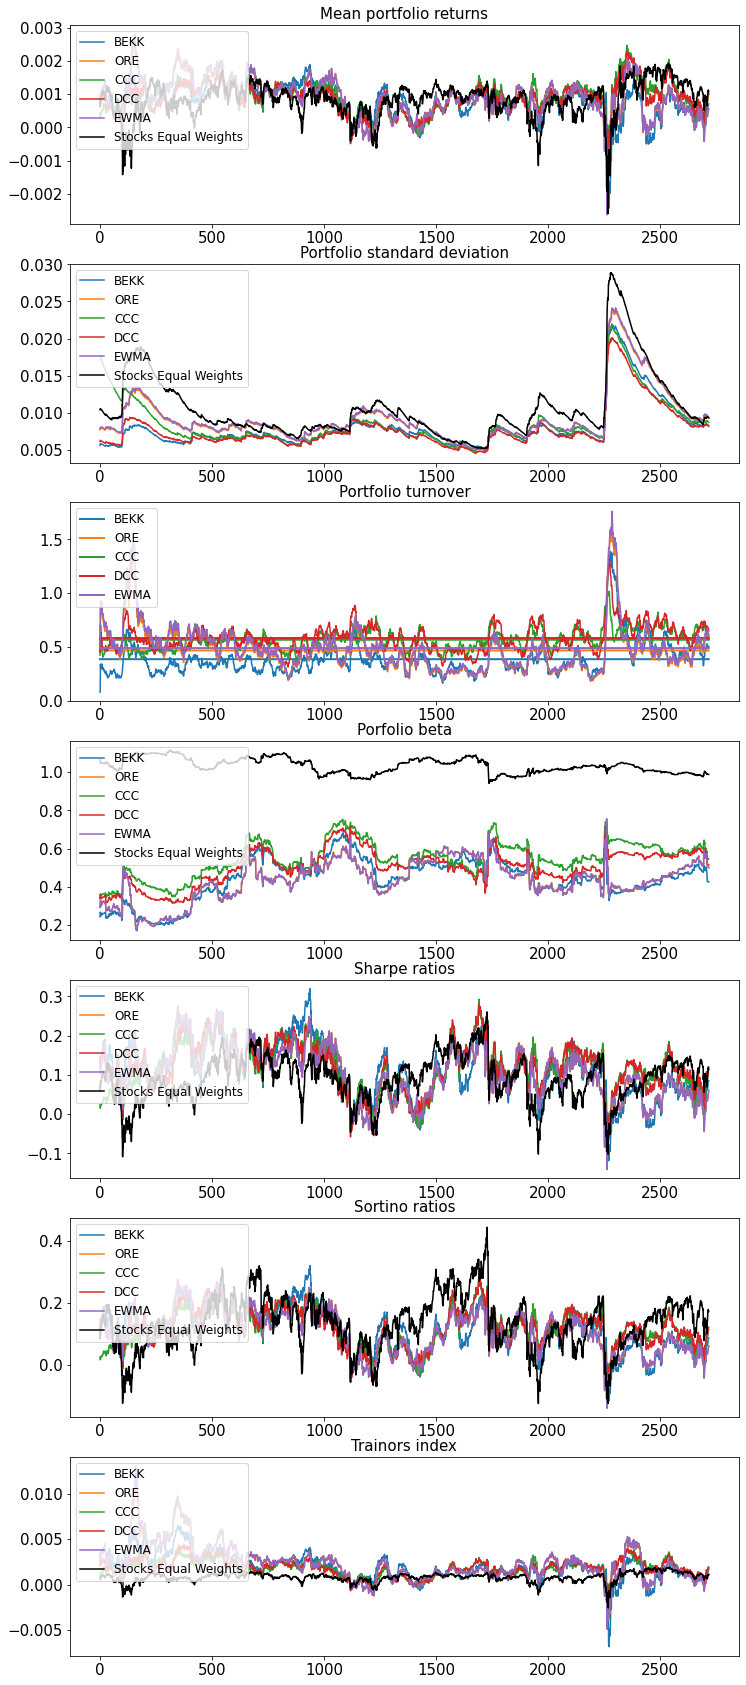

In [57]:
ind =init_step
mean_disc_tuple = (svech_mean_ret_disc,ore_mean_ret_disc,ccc_mean_ret_disc,
                   dcc_mean_ret_disc,ewma_mean_ret_disc,eq_mean_ret_disc)
mean_tuple = (svech_mean_ret,ore_mean_ret,ccc_mean_ret,dcc_mean_ret,
              ewma_mean_ret,eq_mean_ret)
var_mean_tuple = (svech_mean_var, ore_mean_var,ccc_mean_var, dcc_mean_var,ewma_mean_var, eq_mean_var)
mean_turnover_tuple = (mean_turn_svech, mean_turn_ore,mean_turn_ccc, mean_turn_dcc, mean_turn_ewma)
mean_beta_tuple= (svech_mean_beta,ore_mean_beta,ccc_mean_beta,dcc_mean_beta,ewma_mean_beta)

mean_sharpe_tuple =  (svech_mean_SR,ore_mean_SR,ccc_mean_SR,dcc_mean_SR,ewma_mean_SR)
mean_sortino_tuple =  (svech_mean_SoR,ore_mean_SoR,ccc_mean_SoR,dcc_mean_SoR,ewma_mean_SoR)
mean_trainor_tuple =  (svech_mean_TI,ore_mean_TI,ccc_mean_TI,dcc_mean_TI,ewma_mean_TI)

eqw_tuple= (eq_mean_ret_disc,eq_mean_var,eq_mean_beta,eq_mean_SR,eq_mean_SoR,eq_mean_TI)

figure = ind_model_performance2(model_names,mean_disc_tuple,var_mean_tuple,
                      mean_turnover_tuple,mean_beta_tuple ,mean_sharpe_tuple,mean_sharpe_tuple,
                      mean_trainor_tuple,eqw_tuple,300,25)

In [58]:
#figure.savefig("Meanvar_candm1.pdf")


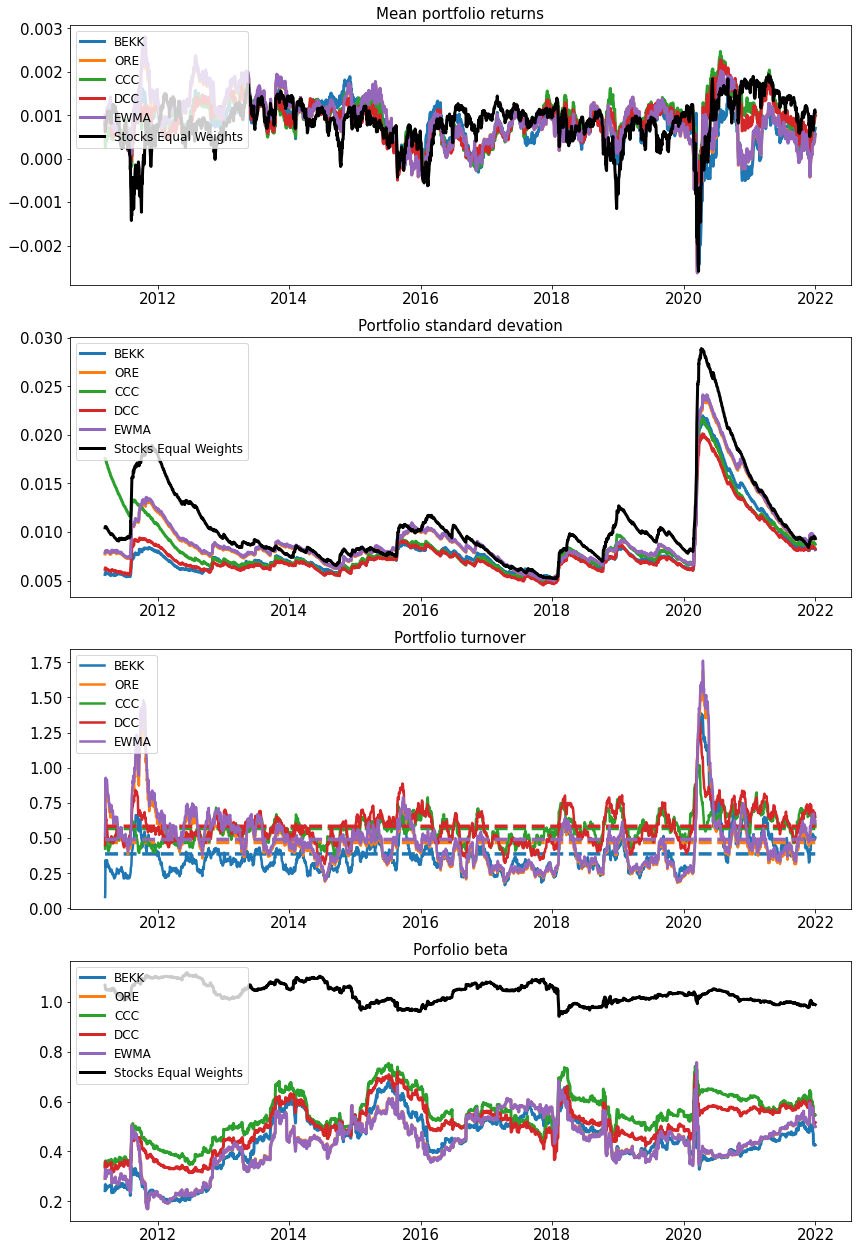

In [59]:
ind =init_step
mean_disc_tuple = (svech_mean_ret_disc,ore_mean_ret_disc,ccc_mean_ret_disc,
                   dcc_mean_ret_disc,ewma_mean_ret_disc,eq_mean_ret_disc)
mean_tuple = (svech_mean_ret,ore_mean_ret,ccc_mean_ret,dcc_mean_ret,
              ewma_mean_ret,eq_mean_ret)
var_mean_tuple = (svech_mean_var, ore_mean_var,ccc_mean_var, dcc_mean_var,ewma_mean_var, eq_mean_var)
mean_turnover_tuple = (mean_turn_svech, mean_turn_ore,mean_turn_ccc, mean_turn_dcc, mean_turn_ewma)
mean_beta_tuple= (svech_mean_beta,ore_mean_beta,ccc_mean_beta,dcc_mean_beta,ewma_mean_beta)

mean_sharpe_tuple =  (svech_mean_SR,ore_mean_SR,ccc_mean_SR,dcc_mean_SR,ewma_mean_SR)
mean_sortino_tuple =  (svech_mean_SoR,ore_mean_SoR,ccc_mean_SoR,dcc_mean_SoR,ewma_mean_SoR)
mean_trainor_tuple =  (svech_mean_TI,ore_mean_TI,ccc_mean_TI,dcc_mean_TI,ewma_mean_TI)

eqw_tuple= (eq_mean_ret_disc,eq_mean_var,eq_mean_beta)

figure = ind_model_performance3(model_names,mean_disc_tuple,var_mean_tuple,
                      mean_turnover_tuple,mean_beta_tuple ,eqw_tuple,300,25)

In [60]:
H_mean_comb = np.zeros((N,N,T))
H_mean_eqw_comb = np.zeros((N,N,T))
M=shifted_mean_weights.shape[0]

if use_composite_est==False:
    for t in range(T):
        H_mean_comb[:,:,t] = (shifted_mean_weights[0,t]* Ht_svech[:,:,t] + shifted_mean_weights[1,t]* Ht_ore[:,:,t] + \
        shifted_mean_weights[2,t] * Ht_ccc[:,:,t]+shifted_mean_weights[3,t] * Ht_dcc[:,:,t] + \
                              shifted_mean_weights[4,t]* Ht_ewma[:,:,t])

        H_mean_eqw_comb[:,:,t] = (1/M* Ht_svech[:,:,t] + 1/M* Ht_ore[:,:,t] + 
        1/M * Ht_ccc[:,:,t] +1/M * Ht_dcc[:,:,t] + 1/M* Ht_ewma[:,:,t])
else:
    for t in range(T):
        H_mean_comb[:,:,t] = (shifted_mean_weights[0,t]* Ht_comp_svech[:,:,t] + shifted_mean_weights[1,t]* Ht_comp_ore[:,:,t]+ \
        shifted_mean_weights[2,t] * Ht_ccc[:,:,t]+shifted_mean_weights[3,t] * Ht_comp_dcc[:,:,t] + \
                              shifted_mean_weights[4,t]* Ht_comp_ewma[:,:,t])

        H_mean_eqw_comb[:,:,t] = (1/M* Ht_comp_svech[:,:,t] + 1/M* Ht_comp_ore[:,:,t] + 
        1/M * Ht_ccc[:,:,t] +1/M * Ht_comp_dcc[:,:,t] + 1/M* Ht_comp_ewma[:,:,t])
        

mean_final_w = meanvar(H_mean_comb, mu, daily_exp_ret)
mean_final_eq_w = meanvar(H_mean_eqw_comb, mu, daily_exp_ret)

In [61]:
a = 1+calc_perf(mean_final_w,ret)
gain=1
for i in range(300,len(a)):
    gain = a[i]*gain
gain

9.004773378018223

0 solid COMBINATION
1 solid SVECH
2 solid ORE
3 solid CCC
4 solid DCC
5 solid EWMA
6 (0, (5, 1)) EQUAL WEIGHTS STOCKS
7 (0, (5, 1)) EQUAL WEIGHTS MODELS


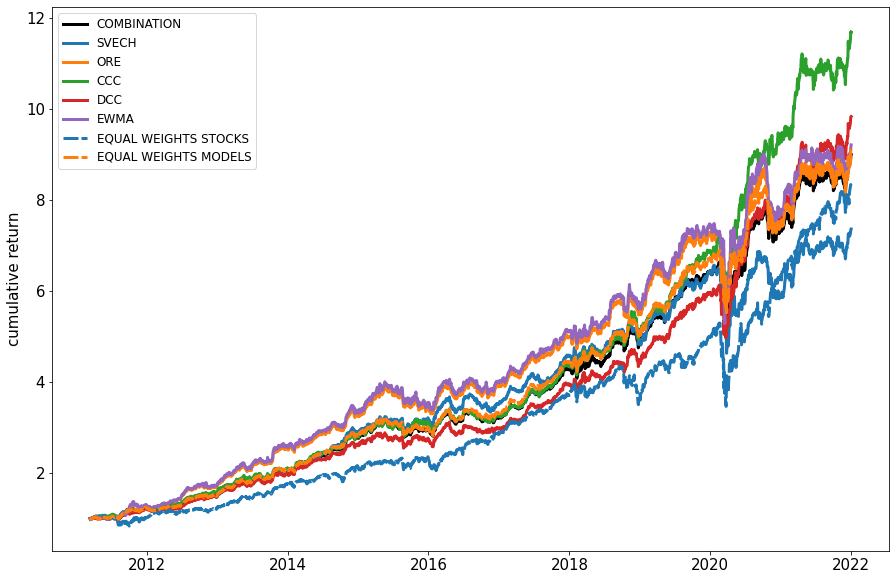

In [63]:
cut_start = 300
cut_end = T
M_consid =  10
m_weights= (mean_final_w[cut_start:cut_end],mean_w_svech[cut_start:cut_end], mean_w_ore[cut_start:cut_end],
            mean_w_ccc[cut_start:cut_end],mean_w_dcc[cut_start:cut_end], mean_w_ewma[cut_start:cut_end],
            equal_weights[cut_start:cut_end],mean_final_eq_w[cut_start:cut_end] )
m_names = ('COMBINATION','SVECH', 'ORE','CCC','DCC','EWMA','EQUAL WEIGHTS STOCKS','EQUAL WEIGHTS MODELS')


a = see_perf(m_weights[:M_consid],m_names[:M_consid],ret[cut_start:cut_end], False)

In [75]:
#a.savefig("covidperf.pdf")

## Min var

In [64]:
use_composite_est = True

In [65]:
# model uses information from t-1 to get the estimate of H_t
# the estimate H_t is used to obtain weights to be used at trading day t
if use_composite_est==False:
    min_w_svech = minvar(Ht_svech)
    min_w_ore = minvar(Ht_ore)
    min_w_ccc = minvar(Ht_ccc)
    min_w_dcc = minvar(Ht_dcc)
    min_w_ewma = minvar(Ht_ewma)
else:
    min_w_svech = minvar(Ht_comp_svech)
    min_w_ore = minvar(Ht_comp_ore)
    min_w_ccc = minvar(Ht_ccc)
    min_w_dcc = minvar(Ht_comp_dcc)
    min_w_ewma = minvar(Ht_comp_ewma)
equal_weights = np.ones((T,N))*1/N


min_turn_svech = calc_turnover(min_w_svech)
min_turn_ore = calc_turnover(min_w_ore)
min_turn_ccc = calc_turnover(min_w_ccc)
min_turn_dcc = calc_turnover(min_w_dcc)
min_turn_ewma = calc_turnover(min_w_ewma)

In [66]:
#The weights for day t estimated using info available at t-1 are used
#To get the real performance during the trading day t using stocks returns observed at time t
svech_min_dperf, svech_min_ret, svech_min_ret_disc =  port_return(min_w_svech,ret,deltas) 
ore_min_dperf, ore_min_ret, ore_min_ret_disc =  port_return(min_w_ore,ret,deltas)
ccc_min_dperf, ccc_min_ret, ccc_min_ret_disc =  port_return(min_w_ccc,ret,deltas)
dcc_min_dperf, dcc_min_ret, dcc_min_ret_disc =  port_return(min_w_dcc,ret,deltas)
ewma_min_dperf, ewma_min_ret, ewma_min_ret_disc  =  port_return(min_w_ewma,ret,deltas)
eq_min_dperf, eq_min_ret, eq_min_ret_disc  =  port_return(equal_weights,ret,deltas)

In [67]:
#use undiscounted mean performance here? Perhpas use yeally rolling mean here instead
#info from time t is used to estimate profolio performance during the trading day t
svech_min_var =  port_variance(svech_min_dperf,svech_min_ret,deltas)
ore_min_var =  port_variance(ore_min_dperf,ore_min_ret,deltas)
ccc_min_var =  port_variance(ccc_min_dperf,ccc_min_ret,deltas)
dcc_min_var =  port_variance(dcc_min_dperf,dcc_min_ret,deltas)
ewma_min_var =  port_variance(ewma_min_dperf,ewma_min_ret,deltas)
eq_min_var =  port_variance(eq_min_dperf,eq_min_ret,deltas)

In [68]:
svech_min_downvar =  port_downside_variance(svech_min_dperf,svech_min_ret,deltas)
ore_min_downvar =  port_downside_variance(ore_min_dperf,ore_min_ret,deltas)
dcc_min_downvar =  port_downside_variance(dcc_min_dperf,dcc_min_ret,deltas)
ccc_min_downvar =  port_downside_variance(ccc_min_dperf,ccc_min_ret,deltas)
ewma_min_downvar =  port_downside_variance(ewma_min_dperf,ewma_min_ret,deltas)
eq_min_downvar =  port_downside_variance(eq_min_dperf,eq_min_ret,deltas)

In [69]:
svech_min_beta =  port_beta(svech_min_dperf, svech_min_ret,SP_ret,deltas)
ore_min_beta =  port_beta(ore_min_dperf, ore_min_ret,SP_ret,deltas)
ccc_min_beta =  port_beta(ccc_min_dperf, ccc_min_ret,SP_ret,deltas)
dcc_min_beta =  port_beta(dcc_min_dperf, dcc_min_ret,SP_ret,deltas)
ewma_min_beta =  port_beta(ewma_min_dperf, ewma_min_ret,SP_ret,deltas) 
eq_min_beta = port_beta(eq_min_dperf, eq_min_ret,SP_ret,deltas)


In [70]:
#Sharpe ratios of the trading day t are obtained from information available at the end of trading day t
svech_min_SR =  sharpe_ratio(svech_min_ret_disc, svech_min_var)
ore_min_SR =  sharpe_ratio(ore_min_ret_disc,ore_min_var)
ccc_min_SR =  sharpe_ratio(ccc_min_ret_disc,ccc_min_var)
dcc_min_SR =  sharpe_ratio(dcc_min_ret_disc,dcc_min_var)
ewma_min_SR =  sharpe_ratio(ewma_min_ret_disc, ewma_min_var)
eq_min_SR = sharpe_ratio(eq_min_ret_disc, eq_min_var)

svech_min_SoR =  sortino_ratio(svech_min_ret_disc, svech_min_downvar)
ore_min_SoR =  sortino_ratio(ore_min_ret_disc,ore_min_downvar)
ccc_min_SoR =  sortino_ratio(ccc_min_ret_disc,ccc_min_downvar)
dcc_min_SoR =  sortino_ratio(dcc_min_ret_disc,dcc_min_downvar)
ewma_min_SoR =  sortino_ratio(ewma_min_ret_disc, ewma_min_downvar)
eq_min_SoR = sortino_ratio(eq_min_ret_disc, eq_min_downvar)


svech_min_TI =  trainors_index(svech_min_ret_disc, svech_min_beta)
ore_min_TI =  trainors_index(ore_min_ret_disc, ore_min_beta)
ccc_min_TI =  trainors_index(ccc_min_ret_disc, ccc_min_beta)
dcc_min_TI =  trainors_index(dcc_min_ret_disc, dcc_min_beta)
ewma_min_TI =  trainors_index(ewma_min_ret_disc, ewma_min_beta)
eq_min_TI =  trainors_index(eq_min_ret_disc, eq_min_beta)


<ipython-input-38-451199668720>:70: RuntimeWarning: divide by zero encountered in true_divide
  SR = model_ret/np.sqrt(model_down_variance)


In [71]:
#keep im mind that weights at time t have to detrmine positions for the next day t+1
#To get the weights for trading day t, we need to use the sharpe ratios available at the end of trading day t-1
ni = 1
models = (svech_min_SR,ore_min_SR,ccc_min_SR,dcc_min_SR,ewma_min_SR)
model_names = ('svech_min','ore_min','ccc_min','dcc_min','ewma_min')
M = len(models)
init_positions = np.ones(M) * 1/M

stack = np.stack(arrays = models)
stack= np.where(stack<0, 0, stack)
stack = stack**ni
cum_weights = stack.sum(axis = 0 )
model_min_weights =  stack / cum_weights
model_min_weights[:,0] = init_positions


indx= np.where(cum_weights<=0) #cases when all SRs are below zero - choose equal weights
model_min_weights[:,indx]  =  1/M

shifted_min_weights = np.roll(model_min_weights, -1, axis=1)

#make weights at time t dependent only on info from t-1 by shifting them
shifted_min_weights[:,0] = init_positions
print(shifted_min_weights.shape)
shifted_min_weights = np.insert(model_min_weights, 0, init_positions, axis=1)   # initial setup
shifted_min_weights = np.delete(shifted_min_weights,obj = -1, axis =1)

(5, 3020)


<ipython-input-71-486bab919eac>:13: RuntimeWarning: invalid value encountered in true_divide
  model_min_weights =  stack / cum_weights


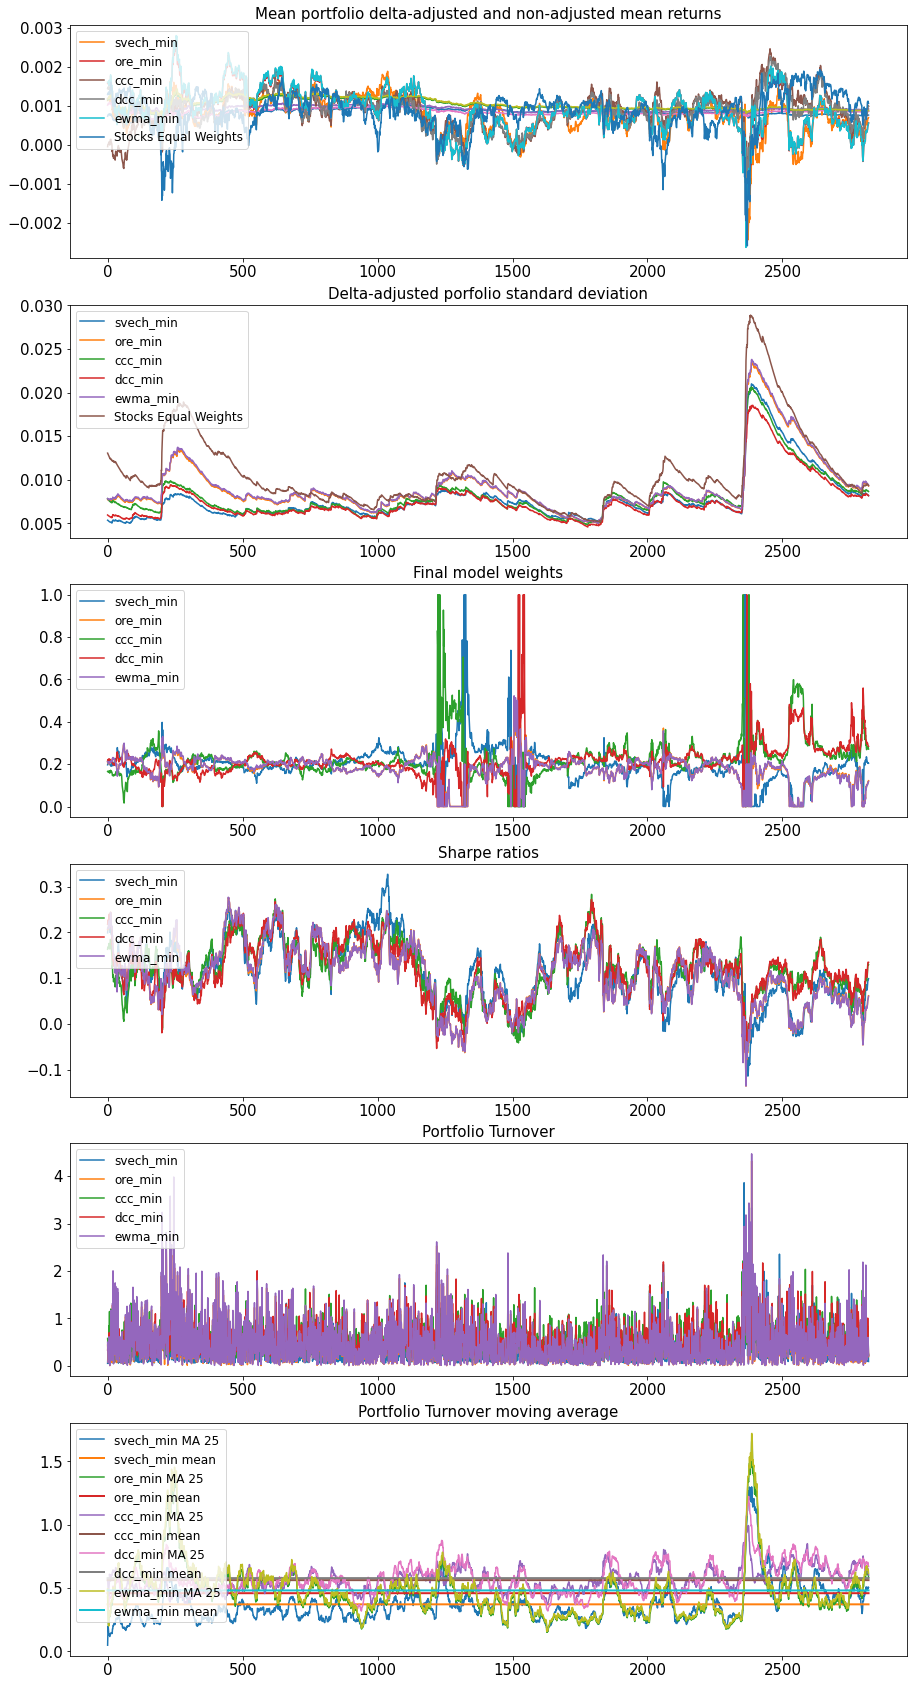

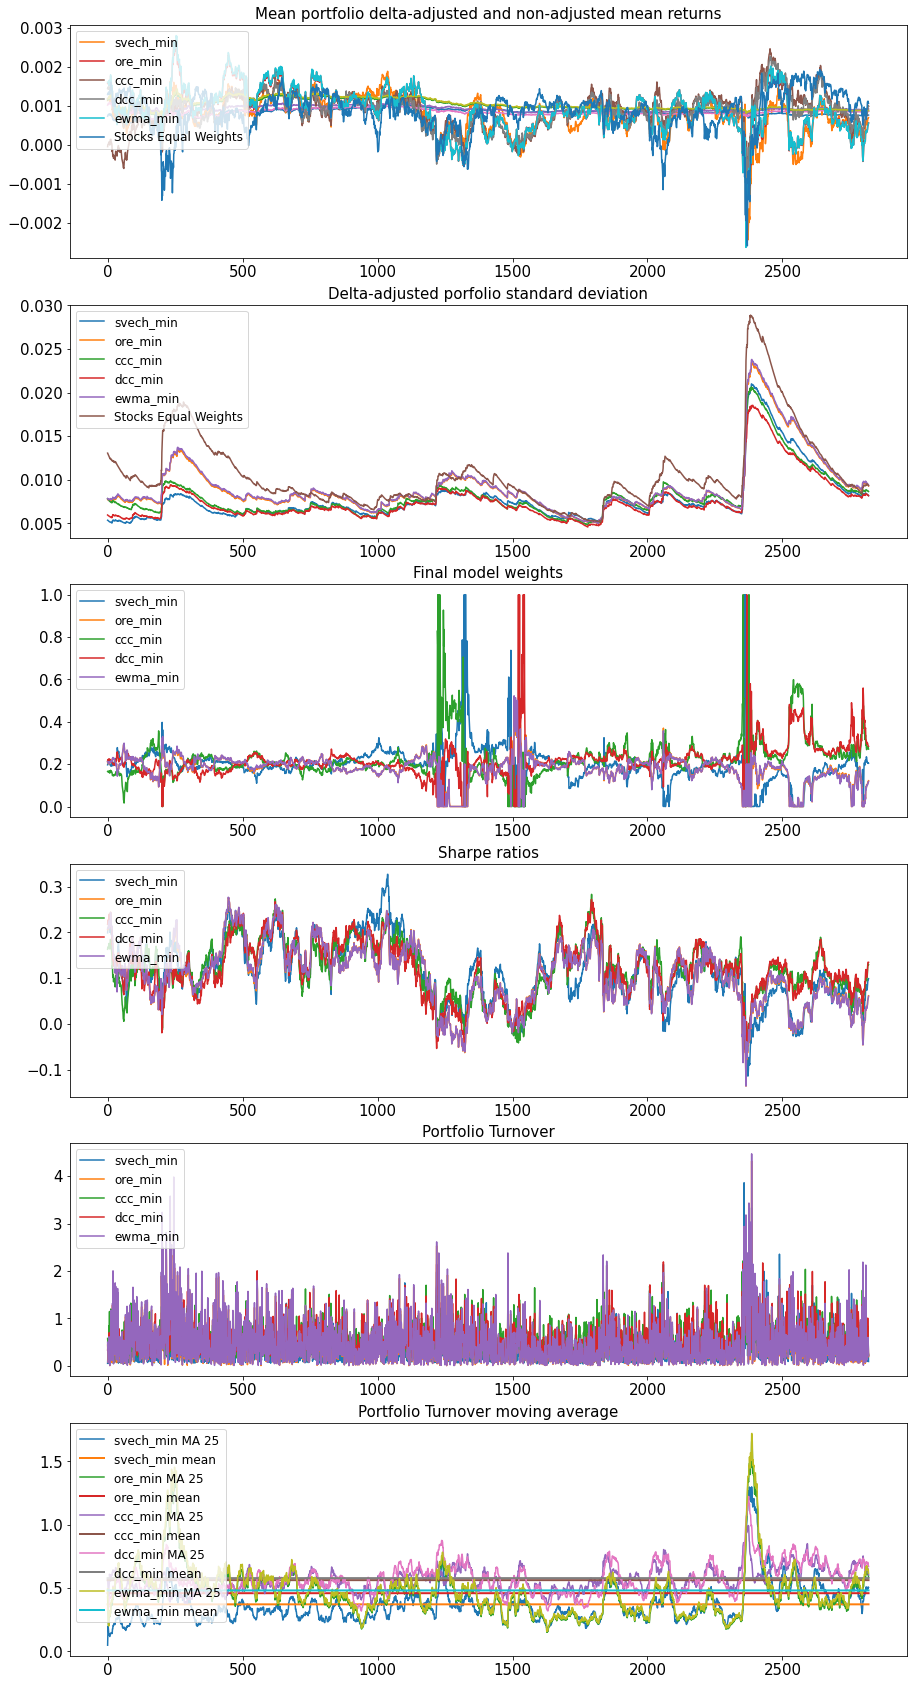

In [72]:
min_avg_tuple = (svech_min_ret,ore_min_ret,ccc_min_ret,dcc_min_ret,ewma_min_ret,
                    eq_min_ret)
min_disc_mean_tuple = (svech_min_ret_disc,ore_min_ret_disc,ccc_min_ret_disc,dcc_min_ret_disc,
                       ewma_min_ret_disc,eq_min_ret_disc)
min_var_tuple = (svech_min_var, ore_min_var,ccc_min_var, dcc_min_var,ewma_min_var,eq_min_var)
min_sharpe_tuple = (svech_min_SR, ore_min_SR,ccc_min_SR, dcc_min_SR,ewma_min_SR,eq_min_SR)
min_sortino_tuple = (svech_min_SoR, ore_min_SoR,ccc_min_SoR, dcc_min_SoR,ewma_min_SoR,eq_min_SoR)
min_sharpe_tuple = (svech_min_SR, ore_min_SR,ccc_min_SR, dcc_min_SR,ewma_min_SR,eq_min_SR)
min_turnover_tuple = (min_turn_svech, min_turn_ore,min_turn_ccc,min_turn_dcc, min_turn_ewma)

ind_model_performance(model_names,min_avg_tuple,min_disc_mean_tuple,min_var_tuple,
                      shifted_min_weights,min_sharpe_tuple,min_turnover_tuple,
                          eq_min_ret_disc,eq_min_var,init_step,25)

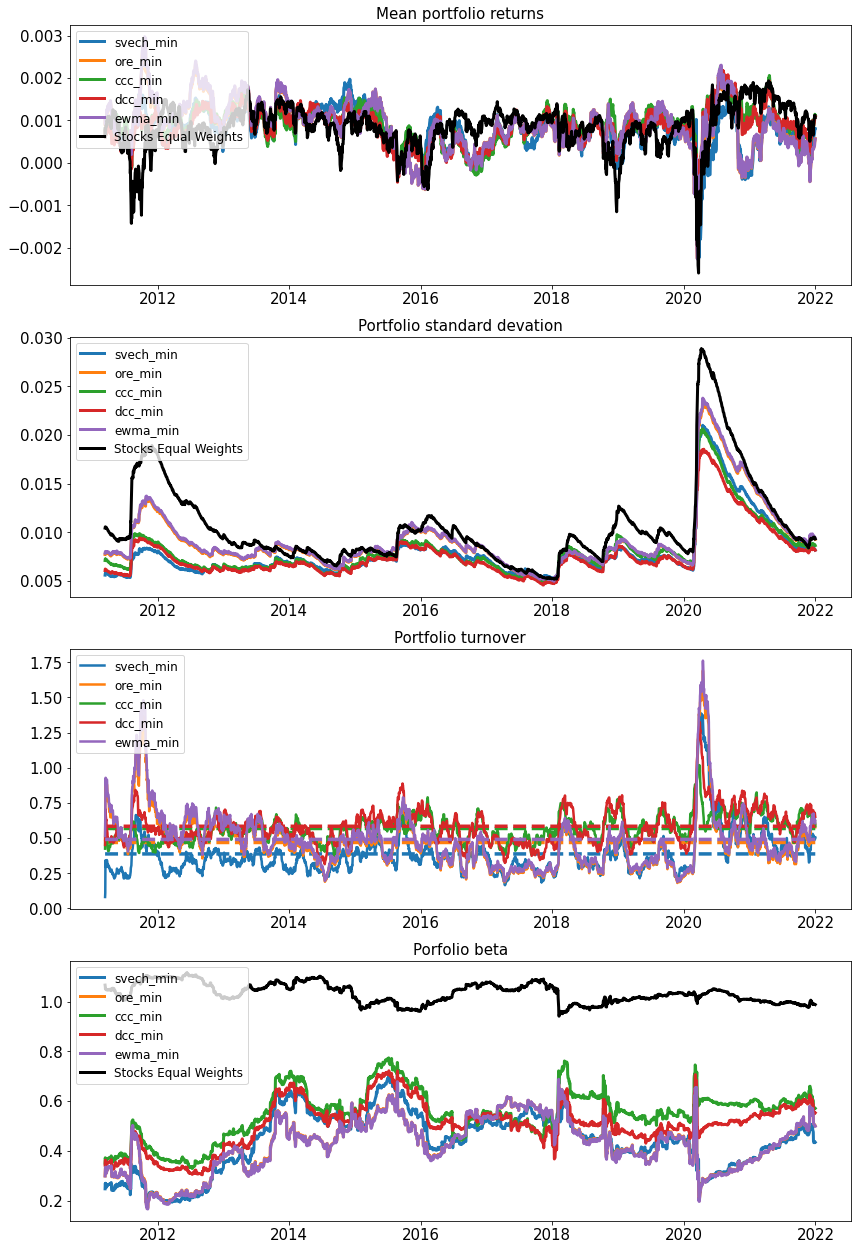

In [73]:
ind =init_step
mean_disc_tuple = (svech_min_ret_disc,ore_min_ret_disc,ccc_min_ret_disc,
                   dcc_min_ret_disc,ewma_min_ret_disc,eq_min_ret_disc)
mean_tuple = (svech_min_ret,ore_min_ret,ccc_min_ret,dcc_min_ret,
              ewma_min_ret,eq_min_ret)
var_min_tuple = (svech_min_var, ore_min_var,ccc_min_var, dcc_min_var,ewma_min_var, eq_min_var)
mean_turnover_tuple = (mean_turn_svech, mean_turn_ore,mean_turn_ccc, mean_turn_dcc, mean_turn_ewma)
mean_beta_tuple= (svech_min_beta,ore_min_beta,ccc_min_beta,dcc_min_beta,ewma_min_beta)

mean_sharpe_tuple =  (svech_min_SR,ore_min_SR,ccc_min_SR,dcc_min_SR,ewma_min_SR)
mean_sortino_tuple =  (svech_min_SoR,ore_min_SoR,ccc_min_SoR,dcc_min_SoR,ewma_min_SoR)
mean_trainor_tuple =  (svech_min_TI,ore_min_TI,ccc_min_TI,dcc_min_TI,ewma_min_TI)

eqw_tuple= (eq_min_ret_disc,eq_min_var,eq_min_beta)

figure = ind_model_performance3(model_names,mean_disc_tuple,var_min_tuple,
                      mean_turnover_tuple,mean_beta_tuple ,eqw_tuple,300,25)


In [74]:
H_min_comb = np.zeros((N,N,T))
H_min_eqw_comb = np.zeros((N,N,T))
M=shifted_mean_weights.shape[0]

if use_composite_est==False:
    for t in range(T):
        H_min_comb[:,:,t] = (shifted_min_weights[0,t]* Ht_svech[:,:,t] + shifted_min_weights[1,t]* Ht_ore[:,:,t] + 
         shifted_min_weights[2,t] * Ht_ccc[:,:,t]+ shifted_min_weights[3,t] * Ht_dcc[:,:,t] + shifted_min_weights[4,t]* Ht_ewma[:,:,t])

        H_min_eqw_comb[:,:,t] = (1/M* Ht_svech[:,:,t] + 1/M* Ht_ore[:,:,t] + 
         1/M * Ht_ccc[:,:,t] + 1/M * Ht_dcc[:,:,t] + 1/M* Ht_ewma[:,:,t])
else:
    for t in range(T):
        H_min_comb[:,:,t] = (shifted_min_weights[0,t]* Ht_comp_svech[:,:,t] + shifted_min_weights[1,t]* Ht_comp_ore[:,:,t] + 
         shifted_min_weights[2,t] * Ht_ccc[:,:,t]+ shifted_min_weights[3,t] * Ht_comp_dcc[:,:,t] + shifted_min_weights[4,t]* Ht_comp_ewma[:,:,t])

        H_min_eqw_comb[:,:,t] = (1/M* Ht_comp_svech[:,:,t] + 1/M* Ht_comp_ore[:,:,t] + 
         1/M * Ht_ccc[:,:,t] + 1/M * Ht_comp_dcc[:,:,t] + 1/M* Ht_comp_ewma[:,:,t])

min_final_w = minvar(H_mean_comb)
min_final_eqw = minvar(H_min_eqw_comb)

0 solid COMBINATION
1 solid SVECH
2 solid ORE
3 solid CCC
4 solid DCC
5 solid EWMA
6 (0, (5, 1)) EQUAL WEIGHTS STOCKS
7 (0, (5, 1)) EQUAL WEIGHTS MODELS


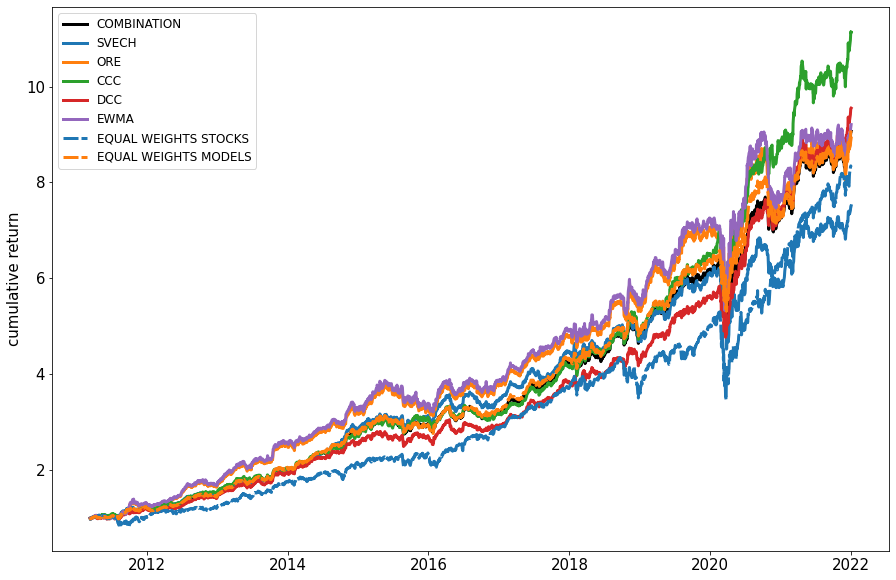

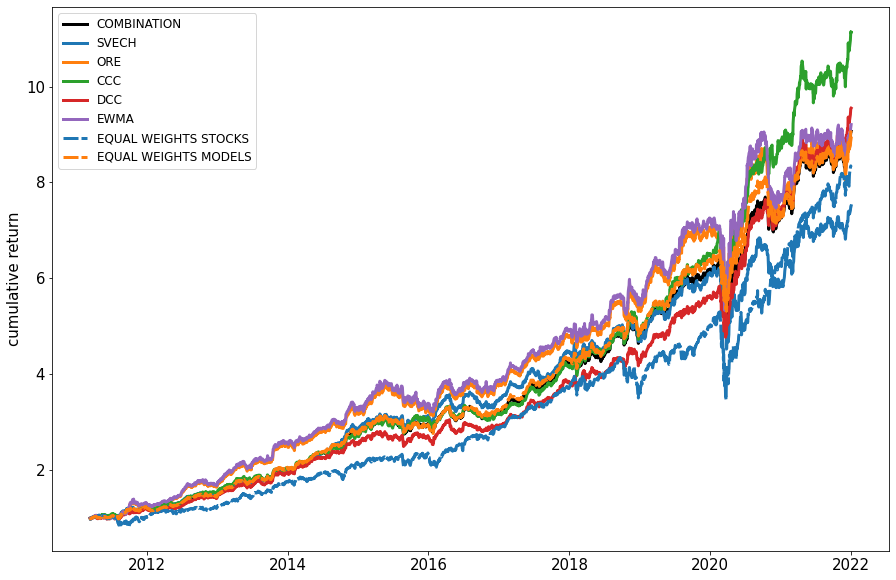

In [75]:
cut_ind = valid_wind
consid_models=8
m_weights= (min_final_w[cut_ind:],min_w_svech[cut_ind:], min_w_ore[cut_ind:],
            min_w_ccc[cut_ind:],min_w_dcc[cut_ind:], min_w_ewma[cut_ind:],equal_weights[cut_ind:],
            min_final_eqw[cut_ind:])
m_names = ('COMBINATION','SVECH', 'ORE','CCC','DCC','EWMA','EQUAL WEIGHTS STOCKS', 'EQUAL WEIGHTS MODELS')

see_perf(m_weights[:consid_models],m_names[:consid_models],ret[cut_ind:], False)

## performance of both aproches combined

0 solid EQUAL WEIGHTS STOCKS
1 solid SVECH mean-var
2 solid ORE mean-var
3 solid CCC mean-var
4 solid DCC mean-var
5 solid EWMA mean-var
6 (0, (5, 1)) SVECH minvar
7 (0, (5, 1)) ORE minvar
8 (0, (5, 1)) CCC minvar
9 (0, (5, 1)) DCC minvar
10 (0, (5, 1)) EWMA minvar


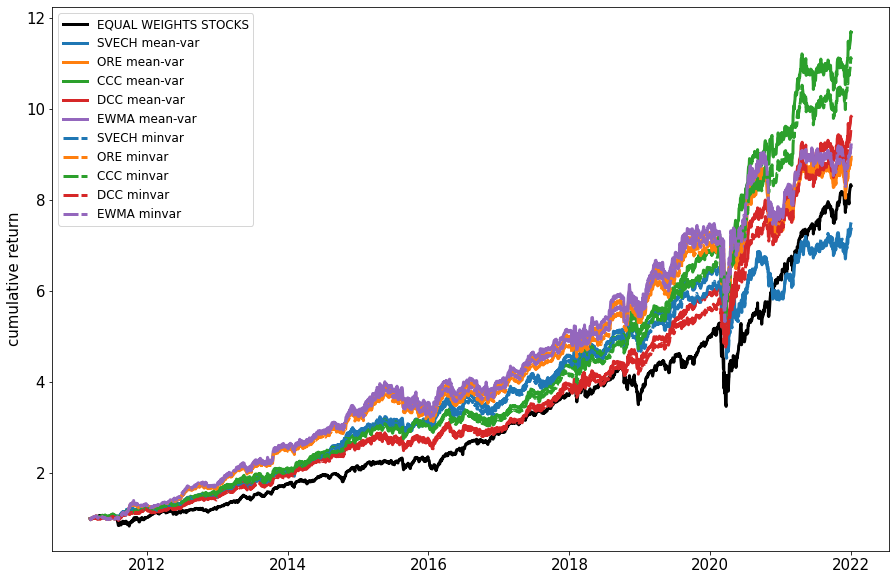

In [76]:
cut_ind = valid_wind
consid_models=20

cut_start = valid_wind

cut_end = T
M_consid =  8
m_weights= (equal_weights[cut_ind:cut_end],mean_w_svech[cut_start:cut_end], mean_w_ore[cut_start:cut_end],
            mean_w_ccc[cut_start:cut_end],mean_w_dcc[cut_start:cut_end], mean_w_ewma[cut_start:cut_end],          
           min_w_svech[cut_start:cut_end], min_w_ore[cut_start:cut_end],
            min_w_ccc[cut_start:cut_end],min_w_dcc[cut_start:cut_end], min_w_ewma[cut_start:cut_end],
           )
m_names = ('EQUAL WEIGHTS STOCKS','SVECH mean-var', 'ORE mean-var','CCC mean-var','DCC mean-var',
           'EWMA mean-var','SVECH minvar', 'ORE minvar','CCC minvar','DCC minvar',
           'EWMA minvar')

candidate_perf = see_perf(m_weights[:consid_models],m_names[:consid_models],ret[cut_ind:cut_end], False)

In [65]:
#candidate_perf.savefig('candgain.pdf')

# Grid estimation
used in numerical study

## Candidate models 

In [66]:
model_names = ('svech','ccc','dcc','ewma')
M = len(model_names)

Ht_svech= Ht_comp_svech
Ht_ore = Ht_comp_ore
Ht_dcc = Ht_comp_dcc
Ht_ewma = Ht_comp_ewma


H_eqw_comb = np.zeros((N,N,T)) #equal weights combination
for t in range(T):
    H_eqw_comb[:,:,t] = (1/M* Ht_comp_svech[:,:,t]  + \
                    1/M * Ht_ccc[:,:,t] +1/M * Ht_comp_dcc[:,:,t] + 1/M* Ht_comp_ewma[:,:,t])
    
    

In [67]:
perf_cand=[]  
validation_win=valid_wind
deltas = np.ones(T)
equal_weights = np.ones((T,N))*1/N
delta_undisct =np.ones(T)
delta = 1 

eq_dperf, eq_ret, eq_ret_disc = port_return(equal_weights,ret,deltas)

avg_turn = calc_turnover(equal_weights).mean()
avg_dret = calc_cum_perf(eq_dperf[validation_win:])[-1]**(1/(T-validation_win))-1                   
 
undisc_var = np.var(eq_dperf[validation_win:])
undisc_downvar =  port_downside_variance(eq_dperf[validation_win:],eq_ret[validation_win:],
                                                     delta_undisct,T-validation_win-1)
undisc_beta = port_beta(eq_dperf[validation_win:], eq_ret[validation_win:],
                                    SP_ret[validation_win:],delta_undisct[validation_win:],T-validation_win-1)
            
avg_dvol = np.sqrt(undisc_var)
avg_beta =undisc_beta[-1]
        
undisc_SR =  sharpe_ratio(eq_ret[-1], undisc_var)
undisc_SoR =  sortino_ratio(eq_ret[-1], undisc_downvar[-1])
undisc_TI =  trainors_index(eq_ret[-1], undisc_beta[-1])
            
avg_SR =undisc_SR
avg_SoR = undisc_SoR
avg_TI = undisc_TI    
    



perf_cand.append(["-----","Equal weights stocks" ,avg_dret, avg_dvol, avg_turn,avg_beta, avg_SR,avg_SoR,avg_TI])

for i in range(2):
    if i ==0:
        daily_exp_ret = 0.0008
        mu = rolling_mean(ret, 500)
        equal_weights_models = meanvar(H_eqw_comb, mu, daily_exp_ret)
        approach='meanvar'
    if i ==1:
        equal_weights_models = minvar(H_eqw_comb)
        approach='minvar'
    
    eq_dperf, eq_ret, eq_ret_disc = port_return(equal_weights_models,ret,deltas)
   #Save the metric we track
    eq_turn= calc_turnover(equal_weights_models)
    avg_turn = eq_turn[validation_win:].mean()  
    avg_dret = calc_cum_perf(eq_dperf[validation_win:])[-1]**(1/(T-validation_win))-1                   
 
    undisc_var = np.var(eq_dperf[validation_win:])
    undisc_downvar =  port_downside_variance(eq_dperf[validation_win:],eq_ret[validation_win:],
                                                     delta_undisct,T-validation_win-1)
    undisc_beta = port_beta(eq_dperf[validation_win:], eq_ret[validation_win:],
                                    SP_ret[validation_win:],delta_undisct[validation_win:],T-validation_win-1)
            
    avg_dvol = np.sqrt(undisc_var)
    avg_beta =undisc_beta[-1]
        
    undisc_SR =  sharpe_ratio(eq_ret[-1], undisc_var)
    undisc_SoR =  sortino_ratio(eq_ret[-1], undisc_downvar[-1])
    undisc_TI =  trainors_index(eq_ret[-1], undisc_beta[-1])
            
    avg_SR =undisc_SR
    avg_SoR = undisc_SoR
    avg_TI = undisc_TI           
    
      
    
    
    perf_cand.append([approach,"Equal weights models" ,avg_dret, avg_dvol, avg_turn,avg_beta, avg_SR,avg_SoR,avg_TI])
    
    
perf_equal_m = pd.DataFrame(perf_cand,columns=['Approach',"Model" ,'avg_dret', 'avg_dvol', 'avg_turn','avg_beta', 'avg_SR','avg_SoR','avg_TI'])
perf_equal_m[["avg_dret",'avg_dvol','avg_TI']] = perf_equal_m[["avg_dret",'avg_dvol','avg_TI']]*100
perf_equal_m

<ipython-input-27-a82ffba585b8>:20: RuntimeWarning: invalid value encountered in true_divide
  w.append(np.divide(np.matmul(Ht_inv, nom), denom))


Approach                 Model  avg_dret  avg_dvol  avg_turn  avg_beta  \
0    -----  Equal weights stocks -0.004447  1.246169  0.000000  1.097789   
1  meanvar  Equal weights models -0.026131  0.788433  0.704311       NaN   
2   minvar  Equal weights models  0.027240  0.722480  0.643732  0.377168   

     avg_SR   avg_SoR    avg_TI  
0  0.003864  0.005278  0.004386  
1       NaN       NaN       NaN  
2  0.039602  0.055361  0.075858

In [68]:
# not dependent on delta or ni 
equal_weights = np.ones((T,N))*1/N
validation_win = 300 # first observation to count in estimation
deltas = np.ones(T)
delta_undisct = deltas
perf_cand=[]



approaches = ['mean-var','minvar']
model_names = ('svech','ore','ccc','dcc','ewma')
cand_model_matrices = (Ht_comp_svech,Ht_comp_ore,Ht_ccc,Ht_comp_dcc,Ht_comp_ewma)
#cand_model_matrices = (Ht_svech_svd,Ht_ore_svd,Ht_ccc,Ht_dcc_svd,Ht_ewma_svd)
mu = rolling_mean(ret, 500) #column vector of expected returns

all_w=[]


for approach in approaches:
    for i,Ht in  tqdm.tqdm(enumerate(cand_model_matrices)):  
        if approach == 'mean-var':
            daily_exp_ret = 0.0008
            w = meanvar(Ht, mu, daily_exp_ret)
        else:
            w = minvar(Ht)
            
        all_w.append(w)
        turn = calc_turnover(w)
        dperf, cand_ret, ret_disc =  port_return(w,ret,deltas) 
        
        avg_turn = turn[validation_win:].mean()  
        avg_dret = calc_cum_perf(dperf[validation_win:])[-1]**(1/(T-validation_win))-1                   

            #Save the metric we track            
        undisc_var = np.var(dperf[validation_win:])
        undisc_downvar =  port_downside_variance(dperf[validation_win:],cand_ret[validation_win:],
                                                     delta_undisct,T-validation_win-1)
        undisc_beta = port_beta(dperf[validation_win:], cand_ret[validation_win:],
                                    SP_ret[validation_win:],delta_undisct[validation_win:],T-validation_win-1)
            
        avg_dvol = np.sqrt(undisc_var)
        avg_beta =undisc_beta[-1]
            
        undisc_SR =  sharpe_ratio(cand_ret[-1], undisc_var)
        undisc_SoR =  sortino_ratio(cand_ret[-1], undisc_downvar[-1])
        undisc_TI =  trainors_index(cand_ret[-1], undisc_beta[-1])

            
        avg_SR =undisc_SR
        avg_SoR = undisc_SoR
        avg_TI = undisc_TI           


        perf_cand.append([approach,model_names[i], avg_dret, avg_dvol, avg_turn,avg_beta, avg_SR,avg_SoR,avg_TI])

perf_cand_m = pd.DataFrame(perf_cand,columns=['Approach',"Model" ,'avg_dret', 'avg_dvol', 'avg_turn','avg_beta', 'avg_SR','avg_SoR','avg_TI'])
perf_cand_m

0it [00:00, ?it/s]<ipython-input-27-a82ffba585b8>:20: RuntimeWarning: invalid value encountered in true_divide
  w.append(np.divide(np.matmul(Ht_inv, nom), denom))
5it [00:27,  5.59s/it]
5it [00:27,  5.44s/it]


Approach  Model  avg_dret  avg_dvol  avg_turn  avg_beta    avg_SR  \
0  mean-var  svech -0.000291  0.008093  0.478075       NaN       NaN   
1  mean-var    ore -0.000036  0.012149  1.139065       NaN       NaN   
2  mean-var    ccc -0.000457  0.008711  0.857270       NaN       NaN   
3  mean-var    dcc -0.000427  0.007881  0.867521       NaN       NaN   
4  mean-var   ewma -0.000033  0.012343  1.190476       NaN       NaN   
5    minvar  svech  0.000240  0.007411  0.393165  0.312375  0.032344   
6    minvar    ore  0.000428  0.011198  0.948217  0.362863  0.035564   
7    minvar    ccc  0.000099  0.007943  0.830412  0.504349 -0.024424   
8    minvar    dcc  0.000107  0.007257  0.813869  0.438334  0.020224   
9    minvar   ewma  0.000432  0.011366  0.992228  0.361329  0.035270   

    avg_SoR    avg_TI  
0       NaN       NaN  
1       NaN       NaN  
2       NaN       NaN  
3       NaN       NaN  
4       NaN       NaN  
5  0.046475  0.000767  
6  0.051949  0.001098  
7 -0.034000 -0.000385  
8  0.027766  0.000335  
9  0.051475  0.001109

In [69]:
perf_cand_m

Approach  Model  avg_dret  avg_dvol  avg_turn  avg_beta    avg_SR  \
0  mean-var  svech -0.000291  0.008093  0.478075       NaN       NaN   
1  mean-var    ore -0.000036  0.012149  1.139065       NaN       NaN   
2  mean-var    ccc -0.000457  0.008711  0.857270       NaN       NaN   
3  mean-var    dcc -0.000427  0.007881  0.867521       NaN       NaN   
4  mean-var   ewma -0.000033  0.012343  1.190476       NaN       NaN   
5    minvar  svech  0.000240  0.007411  0.393165  0.312375  0.032344   
6    minvar    ore  0.000428  0.011198  0.948217  0.362863  0.035564   
7    minvar    ccc  0.000099  0.007943  0.830412  0.504349 -0.024424   
8    minvar    dcc  0.000107  0.007257  0.813869  0.438334  0.020224   
9    minvar   ewma  0.000432  0.011366  0.992228  0.361329  0.035270   

    avg_SoR    avg_TI  
0       NaN       NaN  
1       NaN       NaN  
2       NaN       NaN  
3       NaN       NaN  
4       NaN       NaN  
5  0.046475  0.000767  
6  0.051949  0.001098  
7 -0.034000 -0.000385  
8  0.027766  0.000335  
9  0.051475  0.001109

In [70]:
perf_cand_m = pd.DataFrame(perf_cand,columns=['Approach',"Model" ,'avg_dret', 'avg_dvol', 'avg_turn','avg_beta', 'avg_SR','avg_SoR','avg_TI'])
perf_cand_m[["avg_dret",'avg_dvol','avg_TI']] = perf_cand_m[["avg_dret",'avg_dvol','avg_TI']]*100
perf_cand_m.to_csv('canidModelsf3mu8.csv',sep='&', float_format='%.3f',index=False)
perf_cand_m

Approach  Model  avg_dret  avg_dvol  avg_turn  avg_beta    avg_SR  \
0  mean-var  svech -0.029108  0.809304  0.478075       NaN       NaN   
1  mean-var    ore -0.003600  1.214850  1.139065       NaN       NaN   
2  mean-var    ccc -0.045748  0.871091  0.857270       NaN       NaN   
3  mean-var    dcc -0.042665  0.788138  0.867521       NaN       NaN   
4  mean-var   ewma -0.003312  1.234334  1.190476       NaN       NaN   
5    minvar  svech  0.024024  0.741080  0.393165  0.312375  0.032344   
6    minvar    ore  0.042775  1.119815  0.948217  0.362863  0.035564   
7    minvar    ccc  0.009860  0.794292  0.830412  0.504349 -0.024424   
8    minvar    dcc  0.010740  0.725734  0.813869  0.438334  0.020224   
9    minvar   ewma  0.043191  1.136599  0.992228  0.361329  0.035270   

    avg_SoR    avg_TI  
0       NaN       NaN  
1       NaN       NaN  
2       NaN       NaN  
3       NaN       NaN  
4       NaN       NaN  
5  0.046475  0.076732  
6  0.051949  0.109752  
7 -0.034000 -0.038465  
8  0.027766  0.033484  
9  0.051475  0.110946

In [71]:
perf_cand_m

Approach  Model  avg_dret  avg_dvol  avg_turn  avg_beta    avg_SR  \
0  mean-var  svech -0.029108  0.809304  0.478075       NaN       NaN   
1  mean-var    ore -0.003600  1.214850  1.139065       NaN       NaN   
2  mean-var    ccc -0.045748  0.871091  0.857270       NaN       NaN   
3  mean-var    dcc -0.042665  0.788138  0.867521       NaN       NaN   
4  mean-var   ewma -0.003312  1.234334  1.190476       NaN       NaN   
5    minvar  svech  0.024024  0.741080  0.393165  0.312375  0.032344   
6    minvar    ore  0.042775  1.119815  0.948217  0.362863  0.035564   
7    minvar    ccc  0.009860  0.794292  0.830412  0.504349 -0.024424   
8    minvar    dcc  0.010740  0.725734  0.813869  0.438334  0.020224   
9    minvar   ewma  0.043191  1.136599  0.992228  0.361329  0.035270   

    avg_SoR    avg_TI  
0       NaN       NaN  
1       NaN       NaN  
2       NaN       NaN  
3       NaN       NaN  
4       NaN       NaN  
5  0.046475  0.076732  
6  0.051949  0.109752  
7 -0.034000 -0.038465  
8  0.027766  0.033484  
9  0.051475  0.110946

## Min-var 

In [72]:
perf=[]
validation_win = valid_wind # first observation to count in estimation
mu = rolling_mean(ret, 500) #column vector of expected returns
#approach = 'mean-var'
approach = 'min-var'
candm_weights_minvar=[]
minvar_costadj_gain=[]

delta_undisct =np.ones(T)

metrics =['SR','SoR', 'TI']
#metrics = ['SoR']
delta_list =[1,0.99,0.95,0.9,0.8,0.7] 
ni_list=[1,2,5,10]

if approach == 'mean-var':
    w_svech = meanvar(Ht_comp_svech, mu, daily_exp_ret) 
    w_ore = meanvar(Ht_comp_ore, mu, daily_exp_ret)
    w_ccc= meanvar(Ht_ccc, mu, daily_exp_ret)
    w_dcc= meanvar(Ht_comp_dcc, mu, daily_exp_ret)
    w_ewma= meanvar(Ht_comp_ewma, mu, daily_exp_ret)
else:
    w_svech = minvar(Ht_comp_svech)
    w_ore = minvar(Ht_comp_ore)
    w_ccc= minvar(Ht_ccc)
    w_dcc= minvar(Ht_comp_dcc)
    w_ewma= minvar(Ht_comp_ewma)
    

for delta in tqdm.tqdm(delta_list):
    deltas = np.zeros(T)
    deltas[0] = 1
    deltas[1] = delta
    for t in range(2,T):
        deltas[t] = deltas[t-1]*delta
        
    for ni in ni_list:
        for metric in metrics: 

            svech_dperf, svech_ret, svech_ret_disc =  port_return(w_svech,ret,deltas) 
         #   ore_dperf, ore_ret, ore_ret_disc =  port_return(w_ore,ret,deltas) #crossed out because of simillarity to ewma
            ccc_dperf, ccc_ret, ccc_ret_disc = port_return(w_ccc,ret,deltas)
            dcc_dperf, dcc_ret, dcc_ret_disc =  port_return(w_dcc,ret,deltas)
            ewma_dperf, ewma_ret, ewma_ret_disc  =  port_return(w_ewma,ret,deltas)
        

            svech_var =  port_variance(svech_dperf,svech_ret,deltas)
        #    ore_var =  port_variance(ore_dperf,ore_ret,deltas)
            dcc_var =  port_variance(dcc_dperf,dcc_ret,deltas)
            ccc_var =  port_variance(ccc_dperf,ccc_ret,deltas)
            ewma_var =  port_variance(ewma_dperf,ewma_ret,deltas)
         

            svech_downvar =  port_downside_variance(svech_dperf,svech_ret,deltas)
       #     ore_downvar =  port_downside_variance(ore_dperf,ore_ret,deltas)
            dcc_downvar =  port_downside_variance(dcc_dperf,dcc_ret,deltas)
            ccc_downvar =  port_downside_variance(ccc_dperf,ccc_ret,deltas)
            ewma_downvar =  port_downside_variance(ewma_dperf,ewma_ret,deltas)
        
            
            svech_beta =  port_beta(svech_dperf, svech_ret,SP_ret,deltas)
         #   ore_beta =  port_beta(ore_dperf, ore_ret,SP_ret,deltas)
            ccc_beta =  port_beta(ccc_dperf, ccc_ret,SP_ret,deltas)
            dcc_beta =  port_beta(dcc_dperf, dcc_ret,SP_ret,deltas)
            ewma_beta =  port_beta(ewma_dperf, ewma_ret,SP_ret,deltas)
            

            svech_SR =  sharpe_ratio(svech_ret_disc, svech_var)
        #    ore_SR =  sharpe_ratio(ore_ret_disc,ore_var)
            ccc_SR =  sharpe_ratio(ccc_ret_disc,ccc_var)
            dcc_SR =  sharpe_ratio(dcc_ret_disc,dcc_var)
            ewma_SR =  sharpe_ratio(ewma_ret_disc, ewma_var)
            

            svech_SoR =  sortino_ratio(svech_ret_disc, svech_downvar)
          #  ore_SoR =  sortino_ratio(ore_ret_disc,ore_downvar)
            ccc_SoR =  sortino_ratio(ccc_ret_disc,ccc_downvar)
            dcc_SoR =  sortino_ratio(dcc_ret_disc,dcc_downvar)
            ewma_SoR =  sortino_ratio(ewma_ret_disc, ewma_downvar)
         

                              
            svech_TI =  trainors_index(svech_ret_disc, svech_beta)
         #   ore_TI =  trainors_index(ore_ret_disc, ore_beta)
            ccc_TI =  trainors_index(ccc_ret_disc, ccc_beta)
            dcc_TI =  trainors_index(dcc_ret_disc, dcc_beta)
            ewma_TI =  trainors_index(ewma_ret_disc, ewma_beta)
           

            if metric =='SR':
                models = (svech_SR,ccc_SR,dcc_SR,ewma_SR)
            elif metric =='SoR':
                models = (svech_SoR,ccc_SoR,dcc_SoR,ewma_SoR)
            else: #TI chosen
                models = (svech_TI,ccc_TI,dcc_TI,ewma_TI)

            model_names =('svech','ccc','dcc','ewma')
            M = len(models)
            init_positions = np.ones(M) * 1/M

            stack = np.stack(arrays = models)
            stack= np.where(stack<0, 0, stack)
            stack = stack **ni

            cum_weights = stack.sum(axis = 0 )
            model_weights =  stack / cum_weights
            model_weights[:,0] = init_positions

            indx= np.where(cum_weights<=0) #cases when all SRs are below zero - choose equal weights
            model_weights[:,indx]  =  1/M
            model_weights[:,[0,1]] =  1/m # initial setup

            shifted_weights = np.roll(model_weights, -1, axis=1)

            shifted_weights[:,0] = init_positions

            shifted_weights = np.insert(model_weights, 0, init_positions, axis=1)   # initial setup
            shifted_weights = np.delete(shifted_weights,obj = -1, axis =1)

            H_comb = np.zeros((N,N,T))
            
            M=shifted_weights.shape[0]

            for t in range(T):
                H_comb[:,:,t] = (shifted_weights[0,t]* Ht_comp_svech[:,:,t]  + \
                shifted_weights[1,t] * Ht_ccc[:,:,t]+shifted_weights[2,t] * Ht_comp_dcc[:,:,t] + \
                                          shifted_weights[3,t]* Ht_comp_ewma[:,:,t])
            if approach == 'mean-var':
                daily_exp_ret = 0.0005
                final_w = meanvar(H_comb, mu, daily_exp_ret)
            else:
                final_w = minvar(H_comb)
            
     
            final_turn = calc_turnover(final_w)
            final_dperf, final_ret, final_ret_disc =  port_return(final_w,ret,deltas) 
            final_gain_costadj = port_return_costadj(final_w[validation_win:],ret[validation_win:],turn[validation_win:])
            minvar_costadj_gain.append(final_gain_costadj)
            avg_turn = final_turn[validation_win:].mean()  
            avg_dret = calc_cum_perf(final_dperf[validation_win:])[-1]**(1/(T-validation_win))-1                   

            #Save the metric we track            
            undisc_var = np.var(final_dperf[validation_win:])
            undisc_downvar =  port_downside_variance(final_dperf[validation_win:],final_ret[validation_win:],
                                                     delta_undisct,T-validation_win-1)
            undisc_beta = port_beta(final_dperf[validation_win:], final_ret[validation_win:],
                                    SP_ret[validation_win:],delta_undisct[validation_win:],T-validation_win-1)
            
            avg_dvol = np.sqrt(undisc_var)
            avg_beta =undisc_beta[-1]
            
            undisc_SR =  sharpe_ratio(final_ret[-1], undisc_var)
            undisc_SoR =  sortino_ratio(final_ret[-1], undisc_downvar[-1])
            undisc_TI =  trainors_index(final_ret[-1], undisc_beta[-1])
            
            avg_SR =undisc_SR
            avg_SoR = undisc_SoR
            avg_TI = undisc_TI           
                    
            perf.append([approach,metric,delta, ni, avg_dret, avg_dvol, avg_turn,avg_beta, avg_SR,avg_SoR,avg_TI])
            candm_weights_minvar.append(shifted_weights)


  0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-29-451199668720>:42: RuntimeWarning: invalid value encountered in double_scalars
  m_var[t] = np.array(np.matmul(((daily_perf[:t+1]-mu_m[t])**2), deltas[:t+1][::-1]).sum()*1/t)
<ipython-input-29-451199668720>:54: RuntimeWarning: invalid value encountered in double_scalars
  m_down_var[t] = np.array(np.matmul((down_perf[:t+1]**2), deltas[:t+1][::-1]).sum()*1/t)
<ipython-input-29-451199668720>:70: RuntimeWarning: divide by zero encountered in true_divide
  SR = model_ret/np.sqrt(model_down_variance)
<ipython-input-72-40c95e7b002c>:106: RuntimeWarning: invalid value encountered in true_divide
  model_weights =  stack / cum_weights
  0%|          | 0/6 [01:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
minvar_df = pd.DataFrame(perf,columns=['approach','metric','delta', 'ni', 'avg_dret', 'avg_dvol', 'avg_turn','avg_beta', 'avg_SR','avg_SoR','avg_TI'])
minvar_df

In [ ]:
minvar_df = pd.DataFrame(perf,columns=['approach','metric','delta', 'ni', 'avg_dret', 'avg_dvol', 'avg_turn','avg_beta', 'avg_SR','avg_SoR','avg_TI'])
minvar_df['new']= minvar_df['approach'] +   minvar_df['delta'].apply(lambda x: "("+str(x))+minvar_df['ni'].apply(lambda x: " ,"+str(x))+ minvar_df['metric'].apply(lambda x: " ,"+str(x)+")")
minvar_output = minvar_df.drop(labels = ['approach','metric','delta','ni'],axis= 1 )
cols =minvar_output.columns.tolist()
cols = cols[-1:] + cols[:-1]
minvar_output[["avg_dret",'avg_dvol','avg_TI']] = minvar_output[["avg_dret",'avg_dvol','avg_TI']]*100
minvar_output = minvar_output[cols]
minvar_output

In [ ]:
minvar_output.sort_values(by='avg_dret', ascending= False).iloc[:10].to_csv('TOP10minvarModelsf3.csv',sep='&', float_format='%.3f',index=False)
minvar_output.sort_values(by='avg_dret', ascending= False)

In [ ]:
#minvar_output.to_csv('minvarModelsf3.csv',sep='&', float_format='%.3f',index=False)

In [ ]:
a=[]
for elem in minvar_costadj_gain:
    a.append(elem[4])
plt.plot(a)

## Mean-var

In [ ]:
perf=[]
candm_weights_meanvar=[]
meanvar_costadj_gain=[]

delta_undisct =np.ones(T)

validation_win = valid_wind # first observation to count in estimation
mu = rolling_mean(ret, 500) #column vector of expected returns
approach = 'mean-var'

metrics =['SR','SoR', 'TI']
#metrics = ['SoR']
delta_list =[1,0.99,0.95,0.9,0.8,0.7] 
ni_list=[1,2,5,10]
#delta_list =[0.7,0.5,0.2]
if approach == 'mean-var':
    w_svech = meanvar(Ht_comp_svech, mu, daily_exp_ret) 
    #w_ore = meanvar(Ht_comp_ore, mu, daily_exp_ret)
    w_ccc= meanvar(Ht_ccc, mu, daily_exp_ret)
    w_dcc= meanvar(Ht_comp_dcc, mu, daily_exp_ret)
    w_ewma= meanvar(Ht_comp_ewma, mu, daily_exp_ret)
else:
    w_svech = minvar(Ht_comp_svech)
    #w_ore = minvar(Ht_comp_ore)
    w_ccc= minvar(Ht_ccc)
    w_dcc= minvar(Ht_comp_dcc)
    w_ewma= minvar(Ht_comp_ewma)
    

for delta in tqdm.tqdm(delta_list):
    deltas = np.zeros(T)
    deltas[0] = 1
    deltas[1] = delta
    for t in range(2,T):
        deltas[t] = deltas[t-1]*delta
        
    for ni in ni_list:
        for metric in metrics: 


           #calc model metrics  
            svech_dperf, svech_ret, svech_ret_disc =  port_return(w_svech,ret,deltas) 
           # ore_dperf, ore_ret, ore_ret_disc =  port_return(w_ore,ret,deltas)
            ccc_dperf, ccc_ret, ccc_ret_disc = port_return(w_ccc,ret,deltas)
            dcc_dperf, dcc_ret, dcc_ret_disc =  port_return(w_dcc,ret,deltas)
            ewma_dperf, ewma_ret, ewma_ret_disc  =  port_return(w_ewma,ret,deltas)
        

            svech_var =  port_variance(svech_dperf,svech_ret,deltas)
         #   ore_var =  port_variance(ore_dperf,ore_ret,deltas)
            dcc_var =  port_variance(dcc_dperf,dcc_ret,deltas)
            ccc_var =  port_variance(ccc_dperf,ccc_ret,deltas)
            ewma_var =  port_variance(ewma_dperf,ewma_ret,deltas)
         

            svech_downvar =  port_downside_variance(svech_dperf,svech_ret,deltas)
          #  ore_downvar =  port_downside_variance(ore_dperf,ore_ret,deltas)
            dcc_downvar =  port_downside_variance(dcc_dperf,dcc_ret,deltas)
            ccc_downvar =  port_downside_variance(ccc_dperf,ccc_ret,deltas)
            ewma_downvar =  port_downside_variance(ewma_dperf,ewma_ret,deltas)
        
            
            svech_beta =  port_beta(svech_dperf, svech_ret,SP_ret,deltas)
          #  ore_beta =  port_beta(ore_dperf, ore_ret,SP_ret,deltas)
            ccc_beta =  port_beta(ccc_dperf, ccc_ret,SP_ret,deltas)
            dcc_beta =  port_beta(dcc_dperf, dcc_ret,SP_ret,deltas)
            ewma_beta =  port_beta(ewma_dperf, ewma_ret,SP_ret,deltas)
            

            svech_SR =  sharpe_ratio(svech_ret_disc, svech_var)
        #    ore_SR =  sharpe_ratio(ore_ret_disc,ore_var)
            ccc_SR =  sharpe_ratio(ccc_ret_disc,ccc_var)
            dcc_SR =  sharpe_ratio(dcc_ret_disc,dcc_var)
            ewma_SR =  sharpe_ratio(ewma_ret_disc, ewma_var)
            

            svech_SoR =  sortino_ratio(svech_ret_disc, svech_downvar)
         #   ore_SoR =  sortino_ratio(ore_ret_disc,ore_downvar)
            ccc_SoR =  sortino_ratio(ccc_ret_disc,ccc_downvar)
            dcc_SoR =  sortino_ratio(dcc_ret_disc,dcc_downvar)
            ewma_SoR =  sortino_ratio(ewma_ret_disc, ewma_downvar)
         

                              
            svech_TI =  trainors_index(svech_ret_disc, svech_beta)
            #ore_TI =  trainors_index(ore_ret_disc, ore_beta)
            ccc_TI =  trainors_index(ccc_ret_disc, ccc_beta)
            dcc_TI =  trainors_index(dcc_ret_disc, dcc_beta)
            ewma_TI =  trainors_index(ewma_ret_disc, ewma_beta)
           

            if metric =='SR':
                models = (svech_SR,ccc_SR,dcc_SR,ewma_SR)
            elif metric =='SoR':
                models = (svech_SoR,ccc_SoR,dcc_SoR,ewma_SoR)
            else: #TI chosen
                models = (svech_TI,ccc_TI,dcc_TI,ewma_TI)

            model_names =('svech','ccc','dcc','ewma')
            M = len(models)
            init_positions = np.ones(M) * 1/M

            stack = np.stack(arrays = models)
            stack= np.where(stack<0, 0, stack)
            stack = stack **ni

            cum_weights = stack.sum(axis = 0 )
            model_weights =  stack / cum_weights
            model_weights[:,0] = init_positions

            indx= np.where(cum_weights<=0) #cases when all SRs are below zero - choose equal weights
            model_weights[:,indx]  =  1/M
            model_weights[:,[0,1]] =  1/len(models) # initial setup

            shifted_weights = np.roll(model_weights, -1, axis=1)

            shifted_weights[:,0] = init_positions

            shifted_weights = np.insert(model_weights, 0, init_positions, axis=1)   # initial setup
            shifted_weights = np.delete(shifted_weights,obj = -1, axis =1)

            H_comb = np.zeros((N,N,T))
            
            M=shifted_weights.shape[0]

            for t in range(T):
                H_comb[:,:,t] = (shifted_weights[0,t]* Ht_comp_svech[:,:,t]  + \
                shifted_weights[1,t] * Ht_ccc[:,:,t]+shifted_weights[2,t] * Ht_comp_dcc[:,:,t] + \
                                          shifted_weights[3,t]* Ht_comp_ewma[:,:,t])
            if approach == 'mean-var':
                daily_exp_ret = 0.0008
                final_w = meanvar(H_comb, mu, daily_exp_ret)
            else:
                final_w = minvar(H_comb)
            
            
            final_turn = calc_turnover(final_w)
            final_dperf, final_ret, final_ret_disc =  port_return(final_w,ret,deltas) 
   
            avg_turn = final_turn[validation_win:].mean()  
            avg_dret = calc_cum_perf(final_dperf[validation_win:])[-1]**(1/(T-validation_win))-1                   

            #Save the metric we track
 
            
            undisc_var = np.var(final_dperf[validation_win:])
            undisc_downvar =  port_downside_variance(final_dperf[validation_win:],final_ret[validation_win:],
                                                     delta_undisct,T-validation_win-1)
            undisc_beta = port_beta(final_dperf[validation_win:], final_ret[validation_win:],
                                    SP_ret[validation_win:],delta_undisct[validation_win:],T-validation_win-1)
            
            final_gain_costadj = port_return_costadj(final_w[validation_win:],ret[validation_win:],turn[validation_win:])
            meanvar_costadj_gain.append(final_gain_costadj)
            
            avg_dvol = np.sqrt(undisc_var)
            avg_beta =undisc_beta[-1]
            
            undisc_SR =  sharpe_ratio(final_ret[-1], undisc_var)
            undisc_SoR =  sortino_ratio(final_ret[-1], undisc_downvar[-1])
            undisc_TI =  trainors_index(final_ret[-1], undisc_beta[-1])
            
            avg_SR =undisc_SR
            avg_SoR = undisc_SoR
            avg_TI = undisc_TI
            perf.append([approach,metric,delta, ni, avg_dret, avg_dvol, avg_turn,avg_beta, avg_SR,avg_SoR,avg_TI])
            candm_weights_meanvar.append(shifted_weights)


In [ ]:
meanvar_df = pd.DataFrame(perf,columns=['approach','metric','delta', 'ni', 'avg_dret', 'avg_dvol', 'avg_turn','avg_beta', 'avg_SR','avg_SoR','avg_TI'])
meanvar_df['new']= meanvar_df['approach'] +   meanvar_df['delta'].apply(lambda x: "("+str(x))+meanvar_df['ni'].apply(lambda x: " ,"+str(x))+ meanvar_df['metric'].apply(lambda x: " ,"+str(x)+")")
meanvar_output = meanvar_df.drop(labels = ['approach','metric','delta','ni'],axis= 1 )
cols = meanvar_output.columns.tolist()
cols = cols[-1:] + cols[:-1]
meanvar_output[["avg_dret",'avg_dvol','avg_TI']] = meanvar_output[["avg_dret",'avg_dvol','avg_TI']]*100
meanvar_output = meanvar_output[cols]
meanvar_output

In [ ]:
meanvar_output.sort_values(by='avg_dret',ascending=False).iloc[:10].to_csv('meanvarModelsf3Top10.csv',sep='&', float_format='%.3f',index=False)
meanvar_output.sort_values(by='avg_dret',ascending=False)

In [ ]:
#meanvar_output.to_csv('meanvarModelsf3.csv',sep='&', float_format='%.3f',index=False)

In [ ]:
a= pd.DataFrame(meanvar_costadj_gain, columns=[0,5,10,15,20], index = meanvar_output['new'])
a= a.sort_values(by=0, ascending= False)
a.to_csv('meancumul.csv',sep='&', float_format='%.3f',index=True)

In [ ]:
a= pd.DataFrame(minvar_costadj_gain, columns=[0,5,10,15,20], index = minvar_output['new'])
a= a.sort_values(by=0, ascending= False)
a.to_csv('mincumul.csv',sep='&', float_format='%.3f',index=True)

In [ ]:
pd.options.display.float_format = '{:,.3f}'.format
a= pd.DataFrame(minvar_costadj_gain, columns=[0,5,10,15,20], index = minvar_output['new'])

a

In [ ]:
meanvar_output

In [ ]:
# figure showed in thesis
model_names=('BEKK', 'CCC', 'DCC', 'EWMA')
fig,axe = plt.subplots(2,3,figsize = (22,10))
x_pos = np.arange(len(model_names))
lst =[1,2,3,21,22,23]
for i,g in enumerate(lst): #  range(len(candm_weights_meanvar)):
    wei = pd.DataFrame(candm_weights_minvar[g].T)
    end = T
    s=300
    x=range(0,5)   
    data= [wei.iloc[s:end,0],wei.iloc[s:end,1], wei.iloc[s:end,2], wei.iloc[s:end,3]]
    #plt.boxplot(wei.iloc[:end,0],wei.iloc[:end,1], wei.iloc[:end,2], wei.iloc[:end,3],wei.iloc[:end,4])
    
    axe[i //3,i %3].boxplot(data , vert = False, showfliers=False)    
    axe[i //3,i %3].set_yticklabels( model_names[:4])
    axe[i //3,i %3].set_xlim(-0.05,1.05) 
    if i%3 == 0:
        riskmetric ='SR'
    elif  i%3 == 1:
        riskmetric ='SoR'
    else:  riskmetric ='TI'
    title =  riskmetric+ str(r" $\delta=$"  + str(delta_list[g//12])) + r" $\eta=$"+  str(ni_list[((g//6)%4)])
    axe[i //3,i %3].set_title(title)
   # axe[g //3,g %3].boxplot(data , vert = False, showfliers=False)    
    #axe[g //3,g %3].set_yticklabels( model_names[:4])
    #axe[g //3,g %3].set_xlim(-0.05,1.05) 
    #title =  str(r" $\delta=$"  + str(delta_list[g//9])) + r" $\eta=$"+  str(ni_list[((g//3)%3)])
    #axe[g //3,g %3].set_title(title)
    

In [ ]:
#fig.savefig('minvarweights.pdf')

In [ ]:
# figure showed in thesis
model_names=('BEKK', 'CCC', 'DCC', 'EWMA')
fig,axe = plt.subplots(4,3,figsize = (30,35))
x_pos = np.arange(len(model_names))
lst =range(12,24)
for i,g in enumerate(lst): #  range(len(candm_weights_meanvar)):
    wei = pd.DataFrame(candm_weights_meanvar[g].T)
    end = T
    s=300
    x=range(0,5)   
    data= [wei.iloc[s:end,0],wei.iloc[s:end,1], wei.iloc[s:end,2], wei.iloc[s:end,3]]
    #plt.boxplot(wei.iloc[:end,0],wei.iloc[:end,1], wei.iloc[:end,2], wei.iloc[:end,3],wei.iloc[:end,4])
    
    axe[i //3,i %3].boxplot(data , vert = False, showfliers=False)    
    axe[i //3,i %3].set_yticklabels( model_names[:4])
    axe[i //3,i %3].set_xlim(-0.05,1.05) 
    if i%3 == 0:
        riskmetric ='SR'
    elif  i%3 == 1:
        riskmetric ='SoR'
    else:  riskmetric ='TI'
    title = riskmetric+ str(r" $\delta=$"  + str(delta_list[g//12])) + r" $\eta=$"+  str(ni_list[((g//3)%4)])
    axe[i //3,i %3].set_title(title, fontsize = 40)
   # axe[g //3,g %3].boxplot(data , vert = False, showfliers=False)    
    #axe[g //3,g %3].set_yticklabels( model_names[:4])
    #axe[g //3,g %3].set_xlim(-0.05,1.05) 
    #title =  str(r" $\delta=$"  + str(delta_list[g//9])) + r" $\eta=$"+  str(ni_list[((g//3)%3)])
    #axe[g //3,g %3].set_title(title)
    

In [ ]:
 #fig.savefig('meanvarweightsfull.pdf')

In [ ]:
# weight of all portfolios - not showed in thesis because of the size
model_names=('BEKK', 'CCC', 'DCC', 'EWMA')
fig,axe = plt.subplots(int(72/3),3,figsize = (20,90))
x_pos =[ np.arange(len(model_names))]
lst =range(0,72)
for i,g in enumerate(lst): #  range(len(candm_weights_meanvar)):
    wei = pd.DataFrame(candm_weights_meanvar[g].T)
    end = T
    s=300
    x=range(0,5)   
    data= [wei.iloc[s:end,0],wei.iloc[s:end,1], wei.iloc[s:end,2], wei.iloc[s:end,3]]
    #plt.boxplot(wei.iloc[:end,0],wei.iloc[:end,1], wei.iloc[:end,2], wei.iloc[:end,3],wei.iloc[:end,4])
    
    axe[i //3,i %3].boxplot(data , vert = False, showfliers=False)    
    axe[i //3,i %3].set_yticklabels( model_names[:4])
    axe[i //3,i %3].set_xlim(-0.05,1.05) 
    if i%3 == 0:
        riskmetric ='SR'
    elif  i%3 == 1:
        riskmetric ='SoR'
    else:  riskmetric ='TI'
    title =  riskmetric+ str(r" $\delta=$"  + str(delta_list[g//12])) + r" $\eta=$"+  str(ni_list[((g//3)%4)])
    axe[i //3,i %3].set_title(title, fontsize = 10)
   # axe[g //3,g %3].boxplot(data , vert = False, showfliers=False)    
    #axe[g //3,g %3].set_yticklabels( model_names[:4])
    #axe[g //3,g %3].set_xlim(-0.05,1.05) 
    #title =  str(r" $\delta=$"  + str(delta_list[g//9])) + r" $\eta=$"+  str(ni_list[((g//3)%3)])
    #axe[g //3,g %3].set_title(title)
    

In [ ]:
# fig.savefig('minvarweightsfull.pdf')

# Testing the model specification


In [ ]:
estimates_names =[
'EWMA_est',
'EWMA_svd_est',
'EWMA_comp_est',
'EWMA_comp_est_full',
'CCC_est',
'DCC_est',
'DCC_svd_est',
'DCC_comp_est',
'DCC_comp_est_full',
'SVECH_est',
'SVECH_svd_est',
'SVECH_comp_est',
'SVECH_comp_est_full',
'ORE_est',
'ORE_svd_est',
'ORE_comp_est',
'ORE_comp_est_full']


matrices = [Ht_ewma, 
Ht_ewma_svd,
Ht_comp_ewma,
Ht_comp_ewma_full,
Ht_ccc,
Ht_dcc,
Ht_dcc_svd,
Ht_comp_dcc,
Ht_comp_dcc_full,
Ht_svech,
Ht_svech_svd,
Ht_comp_svech,
Ht_comp_svech_full,
Ht_ore,
Ht_ore_svd,
Ht_comp_ore,
Ht_comp_ore_full]


In [ ]:
estimates_names =[
'EWMA_comp_est',
'CCC_est',
'DCC_comp_est',
'SVECH_comp_est',
'ORE_comp_est'
]


matrices = [
Ht_comp_ewma,
Ht_ccc,
Ht_comp_dcc,
Ht_comp_svech,
Ht_comp_ore
]

In [ ]:
def get_trace(C0_inv,Ci):
    mat = np.matmul(Ci.T,C0_inv)
    mat = np.matmul(mat, Ci)
    mat=np.matmul(mat, C0_inv)
    
    return np.trace(mat)
    

def Port_stat(H,ret,h):
    T= H.shape[2]
    N= H.shape[0]
    H_chol_inv = np.zeros((N,N,T))
    H_inv_ret = np.zeros((N,N,T))
    C=np.zeros((N,N,h+1))
    trace = np.zeros(h+1)
    
    test_stat =0
     
    for t in range(T):
        H_chol_inv[:,:,t]= np.linalg.inv(np.linalg.cholesky(H[:,:,t]))
        H_inv_ret[:,:,t] =np.array(np.matmul(H_chol_inv[:,:,t], ret[t,:]),ndmin=2).T
    for j in range(h+1):
        for t in range(j,T):             
            C[:,:,j]=C[:,:,j] + np.matmul(H_inv_ret[:,:,t],H_inv_ret[:,:,t-j].T)
        
        C[:,:,j] = 1/T*C[:,:,j]
    
    C0_inv = np.linalg.inv(C[:,:,0])
    
    for j in range(1,h+1):
        trace[j] = get_trace(C0_inv, C[:,:,j])
        test_stat =test_stat+ 1/(T-j)*trace[j]
   
    return T**2*test_stat

In [ ]:
def Portmantau_stat2(H,ret,h):
    T= H.shape[2]
    N= H.shape[0]
    H_inv = np.zeros((N,N,T))
    H_inv_ret = np.zeros((N,N,T))
    rhr = np.zeros(T)
    test_stat= np.zeros(h+1)
    
    for t in range(T):        
        H_inv[:,:,t] =np.linalg.inv(H[:,:,t])
        rhr[t] = np.matmul(np.matmul(np.array(ret[t,:],ndmin=2), H_inv[:,:,t]),np.array(ret[t,:],ndmin=2).T)       
    test_statj=0
    denomj=0
    
    for j in range(1,h+1):                       
        for t in range(j+1,T+1):
            test_statj += ((rhr[t-1]-N)*(rhr[t-j-1])-N)
            denomj +=  (rhr[t-1]-N)**2   
        test_stat[j]= test_statj/denomj    
    return (test_stat**2).sum()*T

In [ ]:
port_tests1=[]

for matrix in matrices:
    port_tests1.append(Port_stat(matrix[:,:,300:],ret[300:,:],10))


In [ ]:
for i,elem in enumerate(port_tests1):
    print(elem,estimates_names[i])

In [ ]:
port_tests2=[]
for matrix in matrices:
    port_tests2.append(Portmantau_stat2(matrix[:,:,300:],ret[300:,:],10))


In [ ]:
for i,elem in enumerate(port_tests2):
    print(elem,estimates_names[i])

In [ ]:
port_tests=[]

matrices = [Ht_ewma, 
Ht_ewma_svd,
#Ht_comp_ewma,
Ht_ccc,
Ht_dcc,
Ht_dcc_svd,
#Ht_comp_dcc,

Ht_svech,
Ht_svech_svd,
#Ht_comp_svech,

Ht_ore,
Ht_ore_svd]
#Ht_comp_ore]


for matrix in matrices:
    port_tests.append(Portmantau_stat2(matrix[:,:,300:],ret[300:,:],10))


In [ ]:
for elem in port_tests:
    print(elem)